In [2]:
#######################################################################################
##https://github.com/Huma97/Information-Bottleneck-Theory-of-Deep-Learning/tree/master#
#######################################################################################
##讲座7把神经网络可以分层定义，引入可学习激活函数
import os
from collections import defaultdict, OrderedDict#为了自动建目录
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import pickle
from torchvision import datasets
import torchvision.transforms as transforms
import matplotlib as mpl
#import scienceplots
import math
train_on_gpu = torch.cuda.is_available()
##判断是否有GPU
if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')
    
def categorical_cross_entropy(output, target):
    num_classes = 10
    epsilon = 10e-8
        
    output = torch.clamp(output, epsilon, 1. - epsilon)
    ##使用torch.clamp函数将output张量中的值限制在一个范围内，防止出现数值过大或过小的情况，第一个参数是要处理的张量，第二个参数是下限，第三个参数是上限。
    target = target.float()  # Ensure target is float
    target = target.reshape(target.shape[0], 1).to(output.device)  # Move target to the same device as output
    one_hot_target = (target == torch.arange(num_classes).reshape(1, num_classes).to(output.device)).float()
    return torch.mean(-torch.sum(one_hot_target * torch.log(output), 1))
#将target张量转换为独热编码的形式，即将每个类别的索引转换为一个长度为num_classes的向量，其中对应类别的位置为1，其他位置为0。
#最小化这个损失函数意味着我们希望预测值与真实标签之间的差异越小越好，即模型的预测结果与真实情况越接近
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)  # 使用 nn.init.xavier_uniform_对于权系数进行初始化
        m.bias.data.fill_(0.0)  # 使用 fill_ 方法来设置偏置为 0

CUDA is available!  Training on GPU ...


# Downloading MNIST dataset

In [3]:
#分批训练size，Mnist数据集60000=5w：1w
batch_size = 128

# convert data to a normalized torch.FloatTensor
transform = transforms.Compose([
    transforms.ToTensor()])
#    transforms.Normalize((0.1307,), (0.3081,))  # 标准化
#])
# choose the training and test datasets
train_data = datasets.MNIST('./MNIST_data/', download=True, train=True, transform=transform)
test_data = datasets.MNIST('./MNIST_data/', download=True, train=False, transform=transform)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)
#分批载入
full_data_loader = torch.utils.data.DataLoader(test_data, batch_size=10000)
#全部载入测试

# Class for creating NN

In [4]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)  # 输入通道数1，输出通道数16，卷积核大小3x3
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1) # 输入通道数16，输出通道数32，卷积核大小3x3
        self.pool = nn.MaxPool2d(2, 2)                           # 2x2的最大池化层
        self.fc1 = nn.Linear(32 * 7 * 7, 64)                    # 全连接层，输入维度32*7*7，输出维度64
        self.fc2 = nn.Linear(64, 20)                            # 全连接层，输入维度64，输出维度10（对应10个类别）
        self.fc3 = nn.Linear(20, 10)
    def forward(self, x):
        activations = []
        x = F.relu(self.conv1(x))  # 第一层卷积 + ReLU激活 
        xx= torch.flatten(x, 1)
        activations.append(xx.cpu().data.numpy())#layer1
        x = self.pool(x)
        x = F.relu(self.conv2(x))  # 第二层卷积 + ReLU激活
        xx= torch.flatten(x, 1)
        activations.append(xx.cpu().data.numpy())#layer1
        x = self.pool(x)
        x = x.view(-1, 32 * 7 * 7)            # 展平操作，为全连接层做准备
        x = F.relu(self.fc1(x))               # 第一个全连接层 + ReLU激活
        activations.append(x.cpu().data.numpy())#layer1
        x = F.relu(self.fc2(x))               # 第一个全连接层 + ReLU激活
        activations.append(x.cpu().data.numpy())#layer1
        x=self.fc3(x)
        x = torch.softmax(x, dim=1)
        activations.append(x.cpu().data.numpy())
        return x, activations

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Class for saving activations, computing MI and plotting

In [5]:
import kde
# 这段代码是用Python来实现一些熵估计方法，特别是用于估计混合高斯模型的熵。以下是对每个函数的简要解释：
#需要下载https://github.com/Huma97/Information-Bottleneck-Theory-of-Deep-Learning/tree/master，jupyter载入
# get_dists(X):
# 这个函数用来计算输入数据集X中样本之间的成对欧氏距离的平方。它首先计算每个样本向量的平方范数，并将结果扩展为列向量，然后使用矩阵乘法和广播来计算所有样本对之间的距离平方。

# get_shape(x):
# 这个函数用来获取输入矩阵x的形状信息，返回矩阵的列数（特征维度）和行数（样本数）。

# entropy_estimator_kl(x, var):
# 这个函数基于KL散度的方法估计输入数据集x的熵，假设数据集服从多个高斯分布的混合模型。它首先计算数据集中样本之间的成对欧氏距离的平方，然后根据给定的方差var计算距离的对数概率，并最终求取其均值。

# entropy_estimator_bd(x, var):
# 这个函数基于Bhattacharyya系数的方法估计输入数据集x的熵的下界，同样假设数据集服从多个高斯分布的混合模型。它首先利用entropy_estimator_kl函数计算KL散度的估计值，然后加上一个校正项。

# kde_condentropy(output, var):
# 这个函数计算输出的多元高斯分布的条件熵，假设每个维度的方差均为var。
import simplebinmi
#需要下载https://github.com/Huma97/Information-Bottleneck-Theory-of-Deep-Learning/tree/master，jupyter载入
# get_unique_probs(x):
# 这个函数用于计算输入数据集x中每个唯一样本出现的概率。首先，它将输入数据x转换为字节视图，并将其看作是void类型的视图，这样可以方便地比较数据集中的唯一样本。然后，使用NumPy的np.unique函数找到唯一的样本，同时计算出现的次数。最后，将每个唯一样本出现的次数除以总样本数，得到概率值。

# bin_calc_information(inputdata, layerdata, num_of_bins):
# 这个函数用于计算给定输入数据和某一层的输出数据之间的信息量。首先，使用get_unique_probs函数计算输入数据集中每个唯一样本的概率，并将结果存储在p_xs中。然后，将输出数据分成num_of_bins个区间，并计算每个区间中的样本出现的概率。接着，利用信息论中的熵的定义来计算层的熵（H_LAYER）和给定输入的条件下层的熵（H_LAYER_GIVEN_INPUT）。最后，返回两者之差，即信息量。

# bin_calc_information2(labelixs, layerdata, binsize):
# 这个函数也用于计算信息量，与上一个函数相似，但在计算输出的条件熵时使用了一种简化的方法。首先，将层的输出数据划分成多个区间，然后计算每个区间中样本出现的概率。接着，利用这些概率值计算层的熵（H_LAYER）。然后，对于每个标签，通过求取其样本在层输出中的平均位置，计算出条件熵，然后将所有标签对应的条件熵加和。最后，返回层的熵和在给定输出的情况下层的条件熵之差。

In [52]:
class MI_Plate():
    def __init__(self, n_epochs=100, DO_LOWER=False, DO_BINNED=False, PLOT_LAYERS=None):
        super(MI_Plate, self).__init__()
        
        self.n_epochs = n_epochs
        self.DO_LOWER = DO_LOWER
        self.DO_BINNED = DO_BINNED
        self.PLOT_LAYERS = PLOT_LAYERS
#DO_LOWER和DO_BINNED是用于控制数据预处理的布尔值，PLOT_LAYERS是用于指定绘制哪些层的激活值的列表
    def save_activations(self):
        
        if not os.path.exists('activations'):
            print("Making directory", 'activations')
            os.mkdir('activations')
            
        model = Net()
        #model.apply(init_weights)

        optimizer = optim.SGD(model.parameters(), lr=0.01)
        #optimizer = optim.Adam(model.parameters(), lr=0.001)
        # Move model to GPU if available
        if train_on_gpu:
            model.cuda()
        
        for epoch in range(self.n_epochs):
            # monitor training loss
            train_loss = 0.0

            ###################
            # train the model #
            ###################
            model.train()

            for data, target in train_loader:
                if train_on_gpu:
                    data, target = data.cuda(), target.cuda()  # Move data to GPU
                optimizer.zero_grad()
                output, _ = model(data)
                loss = categorical_cross_entropy(output, target)
                # backward
                loss.backward()
                optimizer.step()
                train_loss += loss.item()#*data.size(0)

            # calculate average loss over an epoch
            train_loss = train_loss/len(train_loader.dataset)

            print('Epoch: {} \tTraining Loss: {:.6f}'.format(epoch+1, train_loss))

            model.eval()
########每次按照规定的epoch训练之后，都用full全部数据通过网络一次，记住标签和网络输出
###############################################################################            
            for data, _ in full_data_loader:
                if train_on_gpu:
                    data = data.cuda()  # Move data to GPU
                _, activations = model(data)
#定义多少epoch进行存储每层的输出，前20每次都存，高于200次100次再存一次
            if epoch < 20:       # Log for all first 20 epochs
                fname = 'activations' + "/epoch%08d"% epoch
                print("Saving", fname)
                with open(fname, 'wb') as f:
                    pickle.dump([activations, epoch], f, pickle.HIGHEST_PROTOCOL)
            #pickle.HIGHEST_PROTOCOL 用于指定 pickle 协议的版本，以确保最高的兼容性和效率
            elif (epoch < 100) and (epoch % 5 == 0):    # Then for every 5th epoch
                fname = 'activations' + "/epoch%08d"% epoch
                print("Saving", fname)
                with open(fname, 'wb') as f:
                    pickle.dump([activations, epoch], f, pickle.HIGHEST_PROTOCOL)
            elif (epoch < 200) and (epoch % 10 == 0):    # Then every 10th
                fname = 'activations' + "/epoch%08d"% epoch
                print("Saving", fname)
                with open(fname, 'wb') as f:
                    pickle.dump([activations, epoch], f, pickle.HIGHEST_PROTOCOL)
            elif (epoch % 100 == 0):                # Then every 100th
                fname = 'activations' + "/epoch%08d"% epoch
                print("Saving", fname)
                with open(fname, 'wb') as f:
                    pickle.dump([activations, epoch], f, pickle.HIGHEST_PROTOCOL)
         #####################****************************************
            correct = 0
            total = 0
            with torch.no_grad():
                for data, target in test_loader:  # Assuming test_loader is defined elsewhere
                    if train_on_gpu:
                        data, target = data.cuda(), target.cuda()  # Move data to GPU
                    output, _ = model(data)
                    _, predicted = torch.max(output.data, 1)
                    total += target.size(0)
                    correct += (predicted == target).sum().item()

            accuracy = 100 * correct / total
           
            print('Test Accuracy on 10,000 images: {:.2f}%'.format(accuracy))                    
      ###########################
    def compute_MI(self, noise_variance=1e-1):
        
        MAX_EPOCHS = self.n_epochs
        self.noise_variance = noise_variance
        
        def entropy_func_upper(x):
            return kde.entropy_estimator_kl(x,self.noise_variance)
        
        def entropy_func_lower(x):
            return kde.entropy_estimator_bd(x,self.noise_variance)

        # nats to bits conversion factor
        nats2bits = 1.0/np.log(2) 


        # Save indexes of tests data for each of the output classes
        saved_labelixs = {}
        for data, targets in full_data_loader:
            trg = targets.numpy()
        for i in range(10):
            saved_labelixs[i] = trg == i

        labelprobs = np.mean(np.eye(10)[test_data.targets], axis=0)

        MI_XM_upper_array = []
        MI_YM_upper_array = []
###这段代码的作用是计算每个类别在数据集中出现的频率，并保存每个类别的索引以供后续使用
        measures = OrderedDict()
        measures['tanh'] = {}

        cur_dir = 'activations'
        if not os.path.exists(cur_dir):
            print("Directory %s not found" % cur_dir)

        # Load files saved during each epoch, and compute MI measures of the activity in that epoch
        print('*** Doing %s ***' % cur_dir)
        for epochfile in sorted(os.listdir(cur_dir)):
            if not epochfile.startswith('epoch'):
                continue

            fname = cur_dir + "/" + epochfile
            with open(fname, 'rb') as f:
                d = pickle.load(f)

            epoch = d[1]
            d = d[0]
            if epoch in measures['tanh']:# Skip this epoch if its already been processed
                continue                # this is a trick to allow us to rerun this cell multiple times)

            if epoch > MAX_EPOCHS:
                continue

            print("Doing", fname)

            num_layers = len(d)

            MI_XM_upper_epoch = []
            MI_YM_upper_epoch = []
            
            if self.PLOT_LAYERS is None:
                PLOT_LAYERS = []
                for lndx in range(num_layers):
                    PLOT_LAYERS.append(lndx)

            cepochdata = defaultdict(list)
            for lndx in range(num_layers):
                activity = d[lndx]

                # Compute marginal entropies
                h_upper = entropy_func_upper(activity)
                if self.DO_LOWER:
                    #h_lower = entropy_func_lower([activity,])[0]
                    h_lower = entropy_func_lower(activity)

                # Layer activity given input. This is simply the entropy of the Gaussian noise
                hM_given_X = kde.kde_condentropy(activity, self.noise_variance)

                # Compute conditional entropies of layer activity given output
                hM_given_Y_upper=0.
                for i in range(10):
                    hcond_upper = entropy_func_upper(activity[saved_labelixs[i],:])
                    hM_given_Y_upper += labelprobs[i] * hcond_upper

                if self.DO_LOWER:
                    hM_given_Y_lower=0.
                    for i in range(10):
                        hcond_lower = entropy_func_lower(activity[saved_labelixs[i],:])
                        hM_given_Y_lower += labelprobs[i] * hcond_lower

                cepochdata['MI_XM_upper'].append( nats2bits * (h_upper - hM_given_X) )
                cepochdata['MI_YM_upper'].append( nats2bits * (h_upper - hM_given_Y_upper) )
                cepochdata['H_M_upper'  ].append( nats2bits * h_upper )


                MI_XM_upper = nats2bits * (h_upper - hM_given_X)
                MI_YM_upper = nats2bits * (h_upper - hM_given_Y_upper)

                MI_XM_upper_epoch.append(MI_XM_upper)
                MI_YM_upper_epoch.append(MI_YM_upper)
                
                pstr = 'upper: MI(X;M)=%0.3f, MI(Y;M)=%0.3f, h_upper=%0.3f, hM_given_X=%0.3f, hM_given_Y_upper=%0.3f ' % (cepochdata['MI_XM_upper'][-1], cepochdata['MI_YM_upper'][-1], h_upper, hM_given_X, hM_given_Y_upper)
                if self.DO_LOWER:  # Compute lower bounds
                    cepochdata['MI_XM_lower'].append( nats2bits * (h_lower - hM_given_X) )
                    cepochdata['MI_YM_lower'].append( nats2bits * (h_lower - hM_given_Y_lower) )
                    cepochdata['H_M_lower'  ].append( nats2bits * h_lower )
                    pstr += ' | lower: MI(X;M)=%0.3f, MI(Y;M)=%0.3f' % (cepochdata['MI_XM_lower'][-1], cepochdata['MI_YM_lower'][-1])

                if self.DO_BINNED: # Compute binner estimates
                    binxm, binym = simplebinmi.bin_calc_information2(saved_labelixs, activity, 0.5)
                    cepochdata['MI_XM_bin'].append( nats2bits * binxm )
                    cepochdata['MI_YM_bin'].append( nats2bits * binym )
                    pstr += ' | bin: MI(X;M)=%0.3f, MI(Y;M)=%0.3f' % (cepochdata['MI_XM_bin'][-1], cepochdata['MI_YM_bin'][-1])

                print('- Layer %d %s' % (lndx, pstr) )

            measures['tanh'][epoch] = cepochdata
            MI_XM_upper_array.append(MI_XM_upper_epoch)
            MI_YM_upper_array.append(MI_YM_upper_epoch)
             
            #epoch += 1
        MI_XM_upper_array = np.array(MI_XM_upper_array)
        MI_YM_upper_array = np.array(MI_YM_upper_array)

    # Save the results as arrays
        np.save('D:/深度学习与信息论/MI_XM_upper_array.npy', MI_XM_upper_array)
        np.save('D:/深度学习与信息论/MI_YM_upper_array.npy', MI_YM_upper_array)

        with open('MI', 'wb') as f:
            pickle.dump(measures, f, pickle.HIGHEST_PROTOCOL)   

Plate = MI_Plate() #Create class object
Plate.save_activations() #save activations if they weren't saved already
Plate.compute_MI() #compute and save MIs if they weren't saved before

Epoch: 1 	Training Loss: 0.017965
Saving activations/epoch00000000
Test Accuracy on 10,000 images: 20.96%
Epoch: 2 	Training Loss: 0.017716
Saving activations/epoch00000001
Test Accuracy on 10,000 images: 38.20%
Epoch: 3 	Training Loss: 0.012056
Saving activations/epoch00000002
Test Accuracy on 10,000 images: 79.44%
Epoch: 4 	Training Loss: 0.004467
Saving activations/epoch00000003
Test Accuracy on 10,000 images: 87.57%
Epoch: 5 	Training Loss: 0.003171
Saving activations/epoch00000004
Test Accuracy on 10,000 images: 89.70%
Epoch: 6 	Training Loss: 0.002431
Saving activations/epoch00000005
Test Accuracy on 10,000 images: 91.17%
Epoch: 7 	Training Loss: 0.001951
Saving activations/epoch00000006
Test Accuracy on 10,000 images: 93.60%
Epoch: 8 	Training Loss: 0.001609
Saving activations/epoch00000007
Test Accuracy on 10,000 images: 94.41%
Epoch: 9 	Training Loss: 0.001372
Saving activations/epoch00000008
Test Accuracy on 10,000 images: 95.42%
Epoch: 10 	Training Loss: 0.001192
Saving acti

[[1.32865487e+01 1.32833346e+01 7.11952972e-01 7.55304282e-02
  1.83565229e-04]
 [1.32921842e+01 1.32877374e+01 4.56978249e+00 1.62439414e+00
  9.94805221e-03]
 [1.32876053e+01 1.32912596e+01 1.32801734e+01 1.31938731e+01
  3.31203913e+00]
 [1.32921842e+01 1.32988323e+01 1.32872123e+01 1.32743142e+01
  3.65313172e+00]
 [1.32795043e+01 1.32875613e+01 1.32874978e+01 1.32798417e+01
  3.67738792e+00]
 [1.32921842e+01 1.32972473e+01 1.32876085e+01 1.32838813e+01
  3.64355577e+00]
 [1.32654154e+01 1.32954862e+01 1.32876519e+01 1.32843979e+01
  3.60423789e+00]
 [1.32883098e+01 1.32882657e+01 1.32876725e+01 1.32848746e+01
  3.56867977e+00]
 [1.32854920e+01 1.32879135e+01 1.32876931e+01 1.32851044e+01
  3.53534607e+00]
 [1.32883098e+01 1.32863285e+01 1.32876924e+01 1.32855564e+01
  3.51900526e+00]
 [1.32914798e+01 1.33009456e+01 1.32877138e+01 1.32855364e+01
  3.49628736e+00]
 [1.32900709e+01 1.33102795e+01 1.32876519e+01 1.32858164e+01
  3.49231775e+00]
 [1.32766865e+01 1.33065812e+01 1.328774

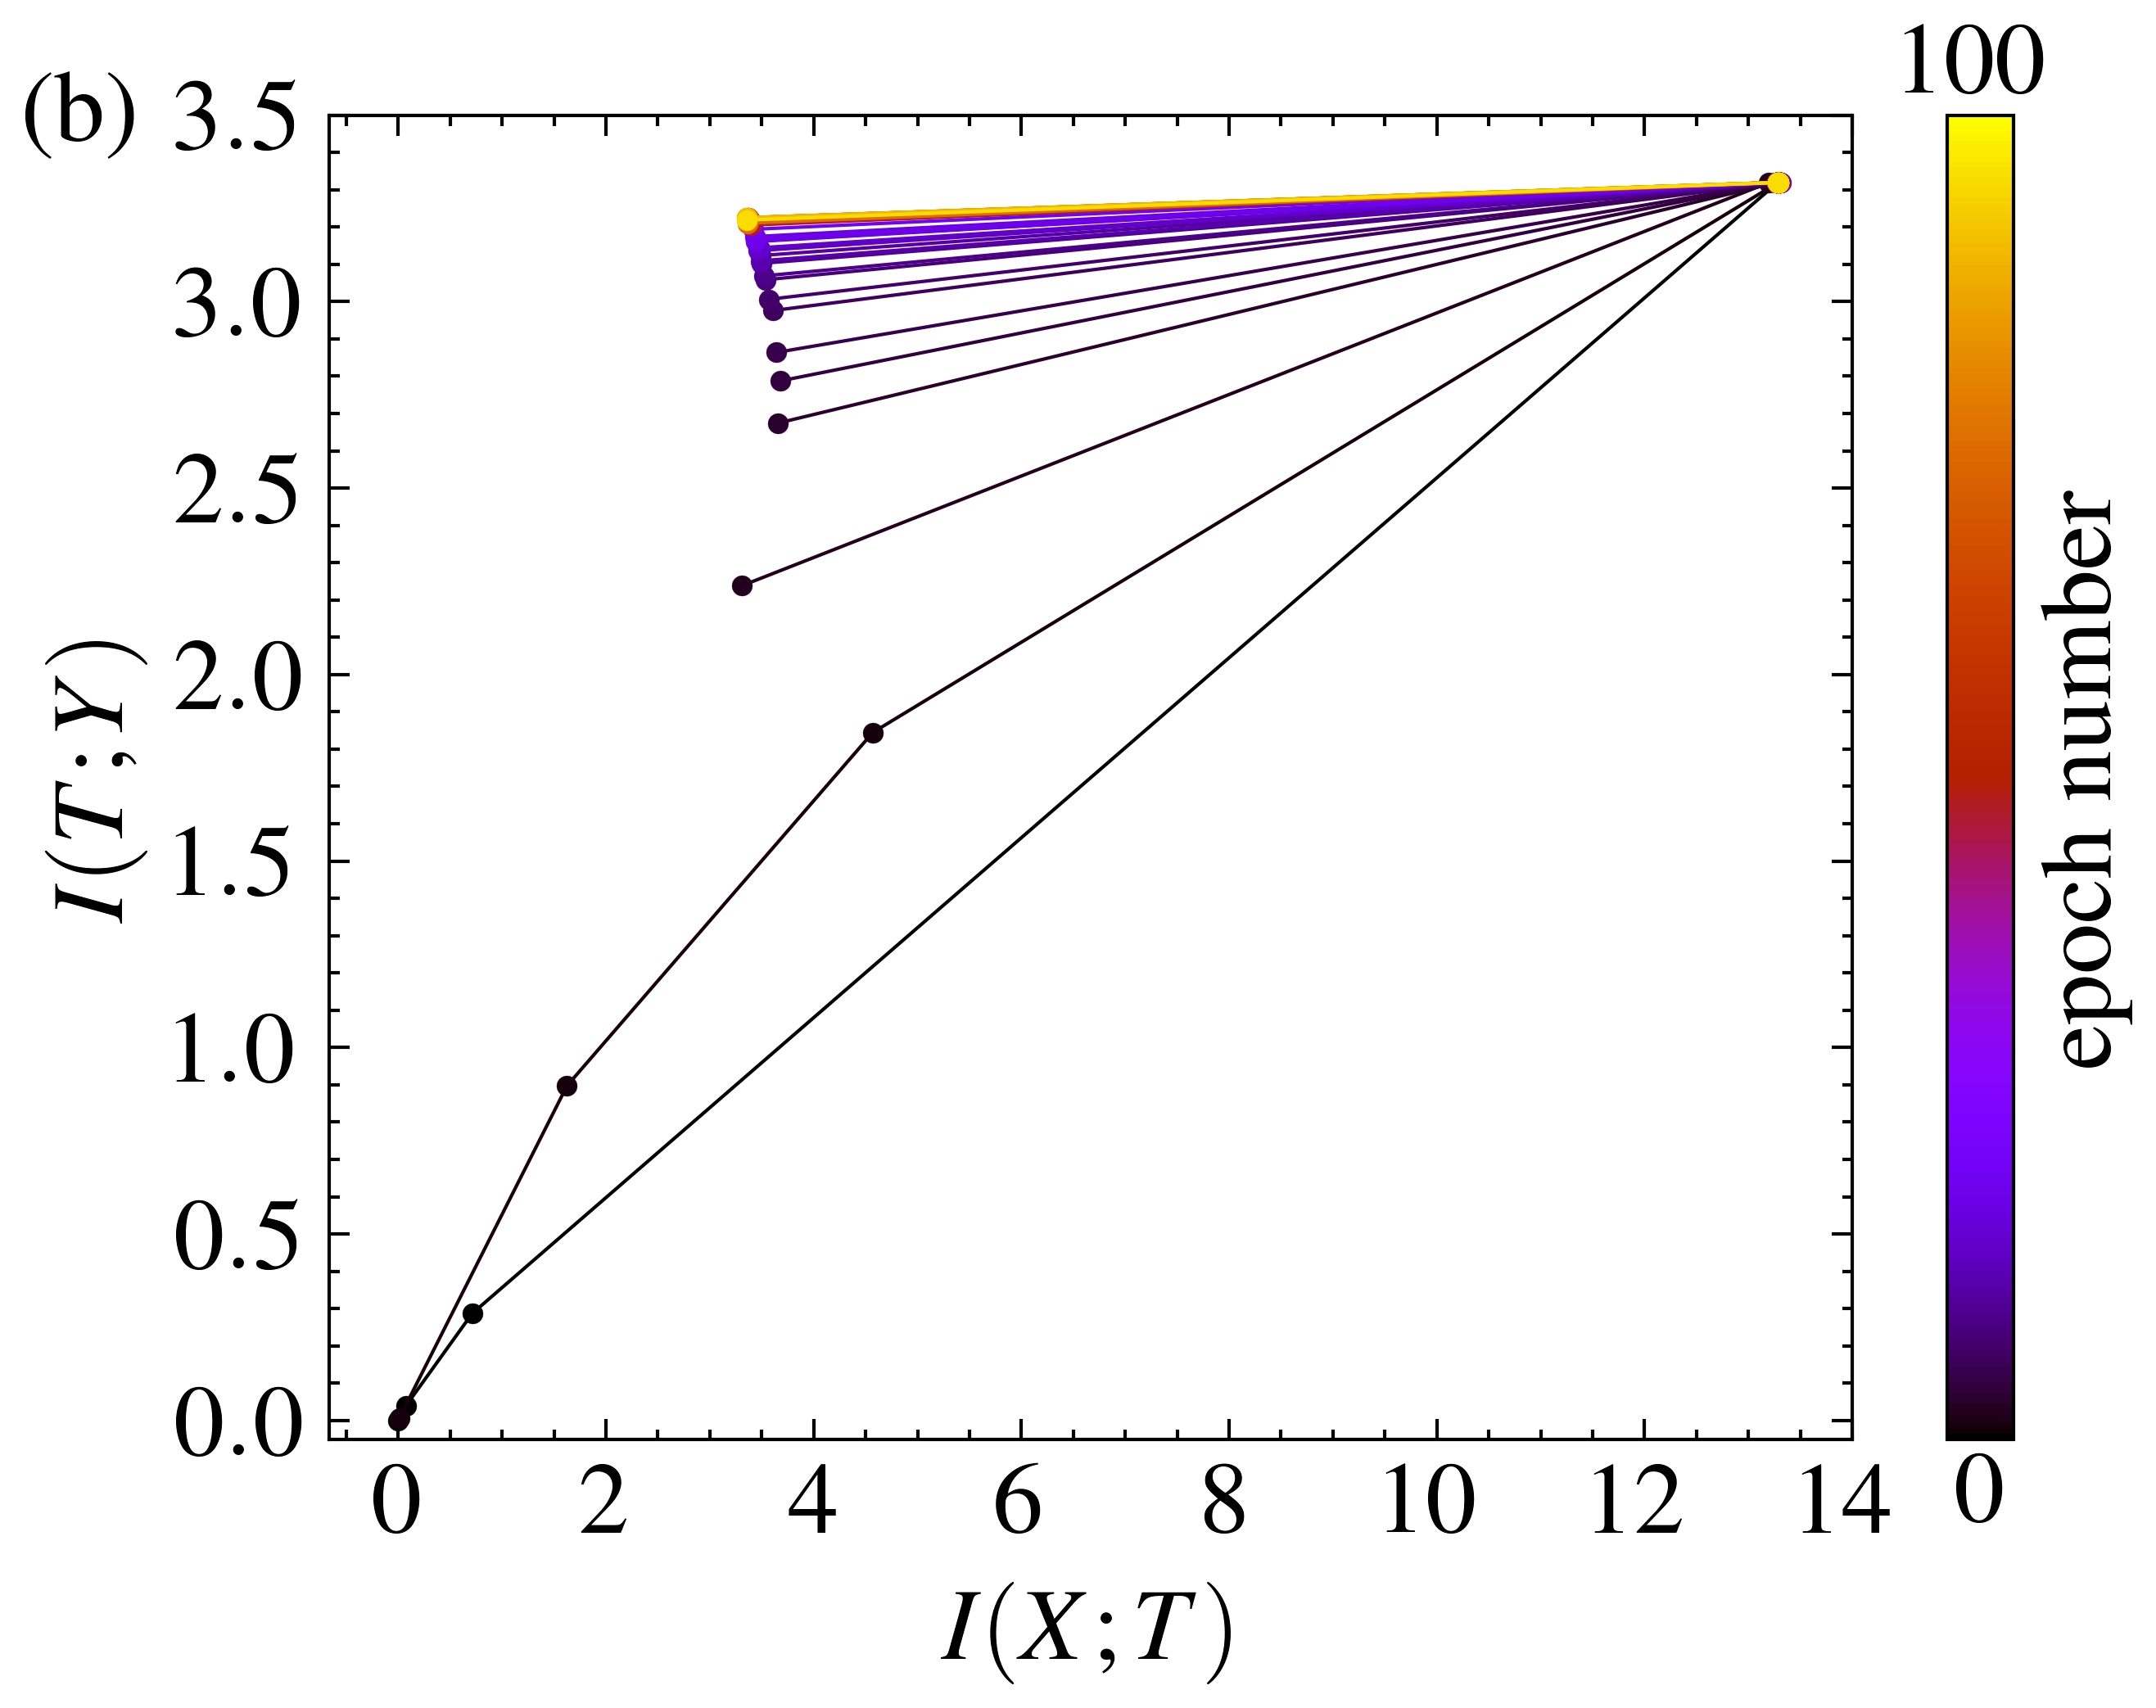

In [54]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import torch
import scienceplots
plt.rcParams['font.serif'] = ['Times New Roman']
mpl.rcParams['figure.dpi'] = 800
mpl.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
plt.style.use(['science', 'ieee'])
mpl.rcParams.update({'font.size': 15})

def plot_information_plane(IXT_array, ITY_array, num_epochs, every_n_early=1, every_n_late=5):
    assert len(IXT_array) == len(ITY_array)

    max_index = len(IXT_array)

    fig, ax = plt.subplots(figsize=(5, 3.5))
    ax.set_xlabel('$I(X;T)$', fontsize=15)
    ax.set_ylabel('$I(T;Y)$', fontsize=15)

    cmap = plt.get_cmap('gnuplot')
    colors = [cmap(i) for i in np.linspace(0, 1, num_epochs + 1)]

    for i in range(0, max_index):
        IXT = IXT_array[i, :]
        ITY = ITY_array[i, :]
        
        # 根据 epoch 的范围调整 every_n
        if i < 20:
            color_idx = i * every_n_early
        else:
            color_idx = 20 * every_n_early + (i - 20) * every_n_late

        ax.plot(IXT, ITY, marker='o', markersize=3, markeredgewidth=0.04,
                linestyle='-', linewidth=0.5, color=colors[color_idx], zorder=10)

    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=1))
    sm._A = []

    # 使用ax参数指定颜色条位置
    cbar = plt.colorbar(sm, ax=ax, ticks=[])
    cbar.set_label('epoch number', fontsize=15)
    cbar.ax.tick_params(labelsize=15)
    cbar.ax.text(0.5, -0.01, 0, transform=cbar.ax.transAxes, va='top', ha='center')
    cbar.ax.text(0.5, 1.0, str(num_epochs), transform=cbar.ax.transAxes, va='bottom', ha='center')

    ax.set_xticks([0, 2, 4, 6, 8, 10, 12, 14])
    ax.set_yticks([0, 0.5, 1, 1.5, 2, 2.5, 3.0, 3.5])
    ax.set_ylim(-0.05, 3.5)  # 修改y轴坐标范围
    # Adjust coordinates of text according to the plot area
    ax.text(-0.2, 0.98, '(b)', fontdict={'size': 15, 'color': 'black'}, transform=ax.transAxes)

    fig.savefig('D:/深度学习与信息论/Fig8bb.eps', dpi=800)
    plt.show()

IXT_array = np.load('D:/深度学习与信息论/MI_XM_upper_array.npy')
print(IXT_array)
ITY_array = np.load('D:/深度学习与信息论/MI_YM_upper_array.npy')
print(ITY_array)

plot_information_plane(IXT_array, ITY_array, num_epochs=100, every_n_early=1, every_n_late=5)

In [55]:
accuracyReLU = [
    20.96, 38.20, 79.44, 87.57, 89.70, 91.17, 93.60, 94.41, 95.42, 95.75,
    96.33, 96.69, 96.29, 96.92, 96.79, 96.95, 97.44, 97.72, 97.55, 97.68,
    98.11, 97.71, 98.07, 97.95, 97.75, 98.32, 98.04, 98.21, 98.15, 98.18,
    98.40, 98.19, 98.18, 98.32, 98.53, 98.57, 98.51, 98.60, 98.55, 98.60,
    98.35, 98.35, 98.61, 98.55, 98.28, 98.33, 98.46, 98.60, 98.66, 98.59,
    98.40, 98.70, 98.69, 98.63, 98.71, 98.71, 98.53, 98.63, 98.73, 98.63,
    98.70, 98.13, 98.80, 98.75, 98.78, 98.59, 98.67, 98.62, 98.60, 98.74,
    98.73, 98.71, 98.79, 98.47, 98.72, 98.52, 98.70, 98.40, 98.70, 98.63,
    98.76, 98.75, 98.69, 98.82, 98.68, 98.79, 98.80, 98.83, 98.71, 98.66,
    98.81, 98.78, 98.76, 98.77, 98.78, 98.71, 98.52, 98.69, 98.62, 98.77
]


In [6]:
class CustomActivation(nn.Module):
    def __init__(self):
        super(CustomActivation, self).__init__()
        self.sigma = nn.Parameter(torch.tensor(0.3))

    def forward(self, input):
        #temp = input/2*(1+torch.erf(input/math.sqrt(2)/self.sigma))#GELU
        temp = input*torch.sigmoid(input/self.sigma)#SiLU
        return temp

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)  # 输入通道数1，输出通道数16，卷积核大小3x3
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1) # 输入通道数16，输出通道数32，卷积核大小3x3
        self.pool = nn.MaxPool2d(2, 2)                           # 2x2的最大池化层
        self.fc1 = nn.Linear(32 * 7 * 7, 64)                    # 全连接层，输入维度32*7*7，输出维度64
        self.fc2 = nn.Linear(64, 20)                            # 全连接层，输入维度64，输出维度10（对应10个类别）
        self.fc3 = nn.Linear(20, 10)
        self.act1 = CustomActivation()
        self.act2 = CustomActivation()
        self.act3 = CustomActivation()
        self.act4 = CustomActivation()
    def forward(self, x):
        activations = []
        x = self.act1(self.conv1(x))  # 第一层卷积 + ReLU激活 
        xx= torch.flatten(x, 1)
        activations.append(xx.cpu().data.numpy())#layer1
        x = self.pool(x)
        x = self.act2(self.conv2(x))  # 第二层卷积 + ReLU激活
        xx= torch.flatten(x, 1)
        activations.append(xx.cpu().data.numpy())#layer1
        x = self.pool(x)
        x = x.view(-1, 32 * 7 * 7)            # 展平操作，为全连接层做准备
        x = self.act3(self.fc1(x))               # 第一个全连接层 + ReLU激活
        activations.append(x.cpu().data.numpy())#layer1
        x = self.act4(self.fc2(x))               # 第一个全连接层 + ReLU激活
        activations.append(x.cpu().data.numpy())#layer1
        x = self.fc3(x)# 第二个全连接层（输出层）
        x = torch.softmax(x, dim=1)
        activations.append(x.cpu().data.numpy())
        return x, activations


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [7]:
class MI_Plate():
    def __init__(self, n_epochs=100, DO_LOWER=False, DO_BINNED=False, PLOT_LAYERS=None):
        super(MI_Plate, self).__init__()
        
        self.n_epochs = n_epochs
        self.DO_LOWER = DO_LOWER
        self.DO_BINNED = DO_BINNED
        self.PLOT_LAYERS = PLOT_LAYERS
#DO_LOWER和DO_BINNED是用于控制数据预处理的布尔值，PLOT_LAYERS是用于指定绘制哪些层的激活值的列表
    def save_activations(self):
        
        if not os.path.exists('activations'):
            print("Making directory", 'activations')
            os.mkdir('activations')
            
        model = Net()
        model.apply(init_weights)

        optimizer = optim.SGD(model.parameters(), lr=0.01)
        #optimizer = optim.Adam(model.parameters(), lr=0.001)
        # Move model to GPU if available
        if train_on_gpu:
            model.cuda()
       
        for epoch in range(self.n_epochs):
            # monitor training loss
            train_loss = 0.0

            ###################
            # train the model #
            ###################
            model.train()

            for data, target in train_loader:
                if train_on_gpu:
                    data, target = data.cuda(), target.cuda()  # Move data to GPU
                optimizer.zero_grad()
                output, _ = model(data)
                loss = categorical_cross_entropy(output, target)
                # backward
                loss.backward()
                optimizer.step()
                train_loss += loss.item()#*data.size(0)

            # calculate average loss over an epoch
            train_loss = train_loss/len(train_loader.dataset)

            print('Epoch: {} \tTraining Loss: {:.6f}'.format(epoch+1, train_loss))

            model.eval()
########每次按照规定的epoch训练之后，都用full全部数据通过网络一次，记住标签和网络输出
###############################################################################            
            for data, _ in full_data_loader:
                if train_on_gpu:
                    data = data.cuda()  # Move data to GPU
                _, activations = model(data)
#定义多少epoch进行存储每层的输出，前20每次都存，高于200次100次再存一次
            if epoch < 20:       # Log for all first 20 epochs
                fname = 'activations' + "/epoch%08d"% epoch
                print("Saving", fname)
                with open(fname, 'wb') as f:
                    pickle.dump([activations, epoch], f, pickle.HIGHEST_PROTOCOL)
            #pickle.HIGHEST_PROTOCOL 用于指定 pickle 协议的版本，以确保最高的兼容性和效率
            elif (epoch < 100) and (epoch % 5 == 0):    # Then for every 5th epoch
                fname = 'activations' + "/epoch%08d"% epoch
                print("Saving", fname)
                with open(fname, 'wb') as f:
                    pickle.dump([activations, epoch], f, pickle.HIGHEST_PROTOCOL)
            elif (epoch < 200) and (epoch % 10 == 0):    # Then every 10th
                fname = 'activations' + "/epoch%08d"% epoch
                print("Saving", fname)
                with open(fname, 'wb') as f:
                    pickle.dump([activations, epoch], f, pickle.HIGHEST_PROTOCOL)
            elif (epoch % 100 == 0):                # Then every 100th
                fname = 'activations' + "/epoch%08d"% epoch
                print("Saving", fname)
                with open(fname, 'wb') as f:
                    pickle.dump([activations, epoch], f, pickle.HIGHEST_PROTOCOL)
         #####################****************************************
            correct = 0
            total = 0
            with torch.no_grad():
                for data, target in test_loader:  # Assuming test_loader is defined elsewhere
                    if train_on_gpu:
                        data, target = data.cuda(), target.cuda()  # Move data to GPU
                    output, _ = model(data)
                    _, predicted = torch.max(output.data, 1)
                    total += target.size(0)
                    correct += (predicted == target).sum().item()

            accuracy = 100 * correct / total
            print('Test Accuracy on 10,000 images: {:.2f}%'.format(accuracy))  
      ###########################
    def compute_MI(self, noise_variance=1e-1):
        
        MAX_EPOCHS = self.n_epochs
        self.noise_variance = noise_variance
        
        def entropy_func_upper(x):
            return kde.entropy_estimator_kl(x,self.noise_variance)
        
        def entropy_func_lower(x):
            return kde.entropy_estimator_bd(x,self.noise_variance)

        # nats to bits conversion factor
        nats2bits = 1.0/np.log(2) 


        # Save indexes of tests data for each of the output classes
        saved_labelixs = {}
        for data, targets in full_data_loader:
            trg = targets.numpy()
        for i in range(10):
            saved_labelixs[i] = trg == i

        labelprobs = np.mean(np.eye(10)[test_data.targets], axis=0)

        MI_XM_upper_array = []
        MI_YM_upper_array = []
###这段代码的作用是计算每个类别在数据集中出现的频率，并保存每个类别的索引以供后续使用
        measures = OrderedDict()
        measures['tanh'] = {}

        cur_dir = 'activations'
        if not os.path.exists(cur_dir):
            print("Directory %s not found" % cur_dir)

        # Load files saved during each epoch, and compute MI measures of the activity in that epoch
        print('*** Doing %s ***' % cur_dir)
        for epochfile in sorted(os.listdir(cur_dir)):
            if not epochfile.startswith('epoch'):
                continue

            fname = cur_dir + "/" + epochfile
            with open(fname, 'rb') as f:
                d = pickle.load(f)

            epoch = d[1]
            d = d[0]
            if epoch in measures['tanh']:# Skip this epoch if its already been processed
                continue                # this is a trick to allow us to rerun this cell multiple times)

            if epoch > MAX_EPOCHS:
                continue

            print("Doing", fname)

            num_layers = len(d)

            MI_XM_upper_epoch = []
            MI_YM_upper_epoch = []
            
            if self.PLOT_LAYERS is None:
                PLOT_LAYERS = []
                for lndx in range(num_layers):
                    PLOT_LAYERS.append(lndx)

            cepochdata = defaultdict(list)
            for lndx in range(num_layers):
                activity = d[lndx]

                # Compute marginal entropies
                h_upper = entropy_func_upper(activity)
                if self.DO_LOWER:
                    #h_lower = entropy_func_lower([activity,])[0]
                    h_lower = entropy_func_lower(activity)

                # Layer activity given input. This is simply the entropy of the Gaussian noise
                hM_given_X = kde.kde_condentropy(activity, self.noise_variance)

                # Compute conditional entropies of layer activity given output
                hM_given_Y_upper=0.
                for i in range(10):
                    hcond_upper = entropy_func_upper(activity[saved_labelixs[i],:])
                    hM_given_Y_upper += labelprobs[i] * hcond_upper

                if self.DO_LOWER:
                    hM_given_Y_lower=0.
                    for i in range(10):
                        hcond_lower = entropy_func_lower(activity[saved_labelixs[i],:])
                        hM_given_Y_lower += labelprobs[i] * hcond_lower

                cepochdata['MI_XM_upper'].append( nats2bits * (h_upper - hM_given_X) )
                cepochdata['MI_YM_upper'].append( nats2bits * (h_upper - hM_given_Y_upper) )
                cepochdata['H_M_upper'  ].append( nats2bits * h_upper )


                MI_XM_upper = nats2bits * (h_upper - hM_given_X)
                MI_YM_upper = nats2bits * (h_upper - hM_given_Y_upper)

                MI_XM_upper_epoch.append(MI_XM_upper)
                MI_YM_upper_epoch.append(MI_YM_upper)
                
                pstr = 'upper: MI(X;M)=%0.3f, MI(Y;M)=%0.3f, h_upper=%0.3f, hM_given_X=%0.3f, hM_given_Y_upper=%0.3f ' % (cepochdata['MI_XM_upper'][-1], cepochdata['MI_YM_upper'][-1], h_upper, hM_given_X, hM_given_Y_upper)
                if self.DO_LOWER:  # Compute lower bounds
                    cepochdata['MI_XM_lower'].append( nats2bits * (h_lower - hM_given_X) )
                    cepochdata['MI_YM_lower'].append( nats2bits * (h_lower - hM_given_Y_lower) )
                    cepochdata['H_M_lower'  ].append( nats2bits * h_lower )
                    pstr += ' | lower: MI(X;M)=%0.3f, MI(Y;M)=%0.3f' % (cepochdata['MI_XM_lower'][-1], cepochdata['MI_YM_lower'][-1])

                if self.DO_BINNED: # Compute binner estimates
                    binxm, binym = simplebinmi.bin_calc_information2(saved_labelixs, activity, 0.5)
                    cepochdata['MI_XM_bin'].append( nats2bits * binxm )
                    cepochdata['MI_YM_bin'].append( nats2bits * binym )
                    pstr += ' | bin: MI(X;M)=%0.3f, MI(Y;M)=%0.3f' % (cepochdata['MI_XM_bin'][-1], cepochdata['MI_YM_bin'][-1])

                print('- Layer %d %s' % (lndx, pstr) )

            measures['tanh'][epoch] = cepochdata
            MI_XM_upper_array.append(MI_XM_upper_epoch)
            MI_YM_upper_array.append(MI_YM_upper_epoch)
             
            #epoch += 1
        MI_XM_upper_array = np.array(MI_XM_upper_array)
        MI_YM_upper_array = np.array(MI_YM_upper_array)

    # Save the results as arrays
        np.save('D:/深度学习与信息论/MI_XM_upper_arrayS.npy', MI_XM_upper_array)
        np.save('D:/深度学习与信息论/MI_YM_upper_arrayS.npy', MI_YM_upper_array)

        with open('MI', 'wb') as f:
            pickle.dump(measures, f, pickle.HIGHEST_PROTOCOL) 

Plate = MI_Plate() #Create class object
Plate.save_activations() #save activations if they weren't saved already
Plate.compute_MI() #compute and save MIs if they weren't saved before

Epoch: 1 	Training Loss: 0.012094
Saving activations/epoch00000000
Test Accuracy on 10,000 images: 86.69%
Epoch: 2 	Training Loss: 0.003012
Saving activations/epoch00000001
Test Accuracy on 10,000 images: 91.43%
Epoch: 3 	Training Loss: 0.002041
Saving activations/epoch00000002
Test Accuracy on 10,000 images: 93.62%
Epoch: 4 	Training Loss: 0.001574
Saving activations/epoch00000003
Test Accuracy on 10,000 images: 94.46%
Epoch: 5 	Training Loss: 0.001282
Saving activations/epoch00000004
Test Accuracy on 10,000 images: 94.37%
Epoch: 6 	Training Loss: 0.001072
Saving activations/epoch00000005
Test Accuracy on 10,000 images: 96.55%
Epoch: 7 	Training Loss: 0.000923
Saving activations/epoch00000006
Test Accuracy on 10,000 images: 96.94%
Epoch: 8 	Training Loss: 0.000825
Saving activations/epoch00000007
Test Accuracy on 10,000 images: 96.88%
Epoch: 9 	Training Loss: 0.000742
Saving activations/epoch00000008
Test Accuracy on 10,000 images: 97.21%
Epoch: 10 	Training Loss: 0.000685
Saving acti

In [8]:

accuracyG = [
    86.69, 91.43, 93.62, 94.46, 94.37, 96.55, 96.94, 96.88, 97.21, 97.29,
    96.50, 97.70, 97.65, 97.82, 97.91, 98.00, 98.01, 97.88, 98.06, 98.35,
    97.99, 98.46, 98.39, 98.53, 98.40, 98.43, 98.59, 98.46, 98.49, 98.61,
    98.44, 98.59, 98.73, 98.65, 98.59, 98.55, 98.55, 98.48, 98.69, 98.65,
    98.65, 98.87, 98.74, 98.49, 98.64, 98.72, 98.80, 98.79, 98.81, 98.69,
    98.82, 98.82, 98.72, 98.84, 98.76, 98.50, 98.82, 98.61, 98.75, 98.88,
    98.79, 98.84, 98.83, 98.80, 98.91, 98.83, 98.86, 98.80, 98.79, 98.83,
    98.91, 98.89, 98.76, 98.79, 98.84, 98.87, 98.96, 98.90, 98.84, 98.83,
    98.81, 98.90
]


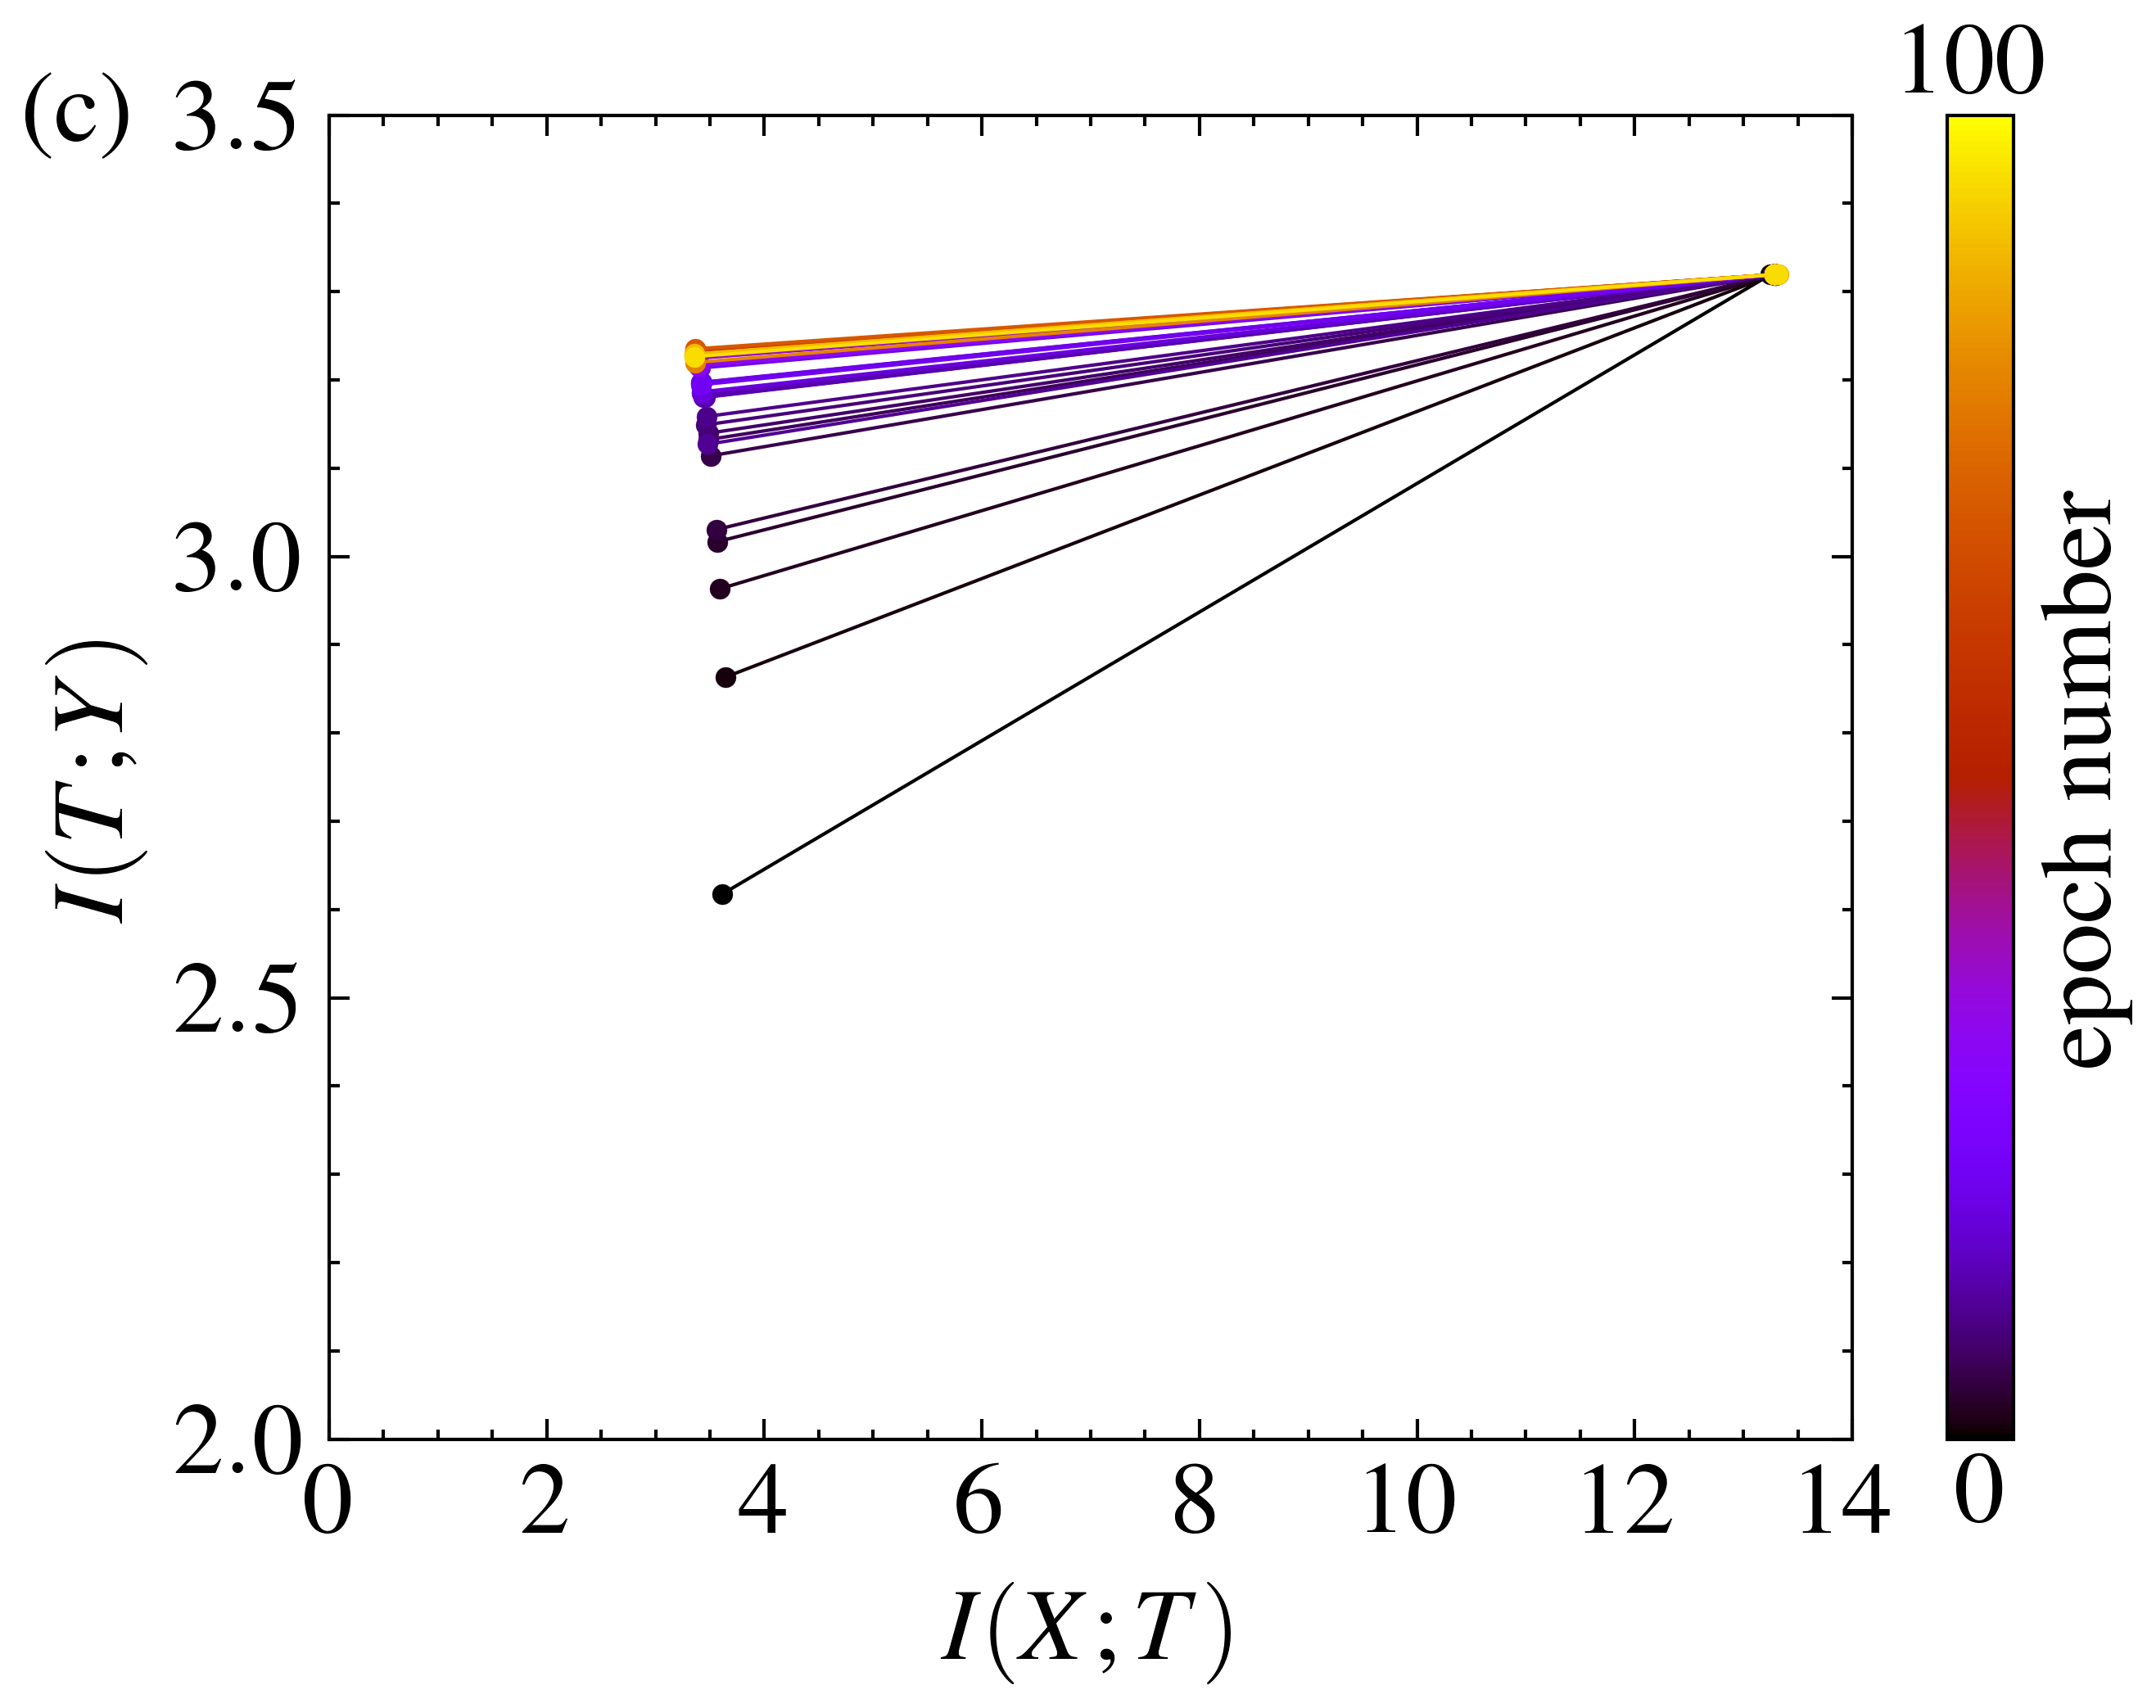

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import torch
import scienceplots
plt.rcParams['font.serif'] = ['Times New Roman']
mpl.rcParams['figure.dpi'] = 800
mpl.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
plt.style.use(['science', 'ieee'])
mpl.rcParams.update({'font.size': 15})

def plot_information_plane(IXT_array, ITY_array, num_epochs, every_n_early=1, every_n_late=5):
    assert len(IXT_array) == len(ITY_array)

    max_index = len(IXT_array)

    fig, ax = plt.subplots(figsize=(5, 3.5))
    ax.set_xlabel('$I(X;T)$', fontsize=15)
    ax.set_ylabel('$I(T;Y)$', fontsize=15)

    cmap = plt.get_cmap('gnuplot')
    colors = [cmap(i) for i in np.linspace(0, 1, num_epochs + 1)]

    for i in range(0, max_index):
        IXT = IXT_array[i, :]
        ITY = ITY_array[i, :]
        
        # 根据 epoch 的范围调整 every_n
        if i < 20:
            color_idx = i * every_n_early
        else:
            color_idx = 20 * every_n_early + (i - 20) * every_n_late

        ax.plot(IXT, ITY, marker='o', markersize=3, markeredgewidth=0.04,
                linestyle='-', linewidth=0.5, color=colors[color_idx], zorder=10)

    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=1))
    sm._A = []

    # 使用ax参数指定颜色条位置
    cbar = plt.colorbar(sm, ax=ax, ticks=[])
    cbar.set_label('epoch number', fontsize=15)
    cbar.ax.tick_params(labelsize=15)
    cbar.ax.text(0.5, -0.01, 0, transform=cbar.ax.transAxes, va='top', ha='center')
    cbar.ax.text(0.5, 1.0, str(num_epochs), transform=cbar.ax.transAxes, va='bottom', ha='center')

    ax.set_xticks([0, 2, 4, 6, 8, 10, 12, 14])
    ax.set_yticks([2.0, 2.5, 3.0, 3.5])
    ax.set_ylim(2.0, 3.5)  # 修改y轴坐标范围
    # Adjust coordinates of text according to the plot area
    ax.text(-0.2, 0.98, '(c)', fontdict={'size': 15, 'color': 'black'}, transform=ax.transAxes)

    fig.savefig('D:/深度学习与信息论/Fig8cc.eps', dpi=800)
    plt.show()

IXT_array = np.load('D:/深度学习与信息论/MI_XM_upper_arrayS.npy')
ITY_array = np.load('D:/深度学习与信息论/MI_YM_upper_arrayS.npy')


plot_information_plane(IXT_array, ITY_array, num_epochs=100, every_n_early=1, every_n_late=5)

In [12]:
IXT_array

array([[13.29570641, 13.28703293, 13.2727217 , 13.24960236,  3.61352003],
       [13.29464975, 13.2865046 , 13.28516568, 13.27744016,  3.64330678],
       [13.29007088, 13.28738515, 13.28647962, 13.28069201,  3.59289185],
       [13.29535419, 13.2847435 , 13.2870568 , 13.28329926,  3.56650696],
       [13.29288865, 13.28897015, 13.28725217, 13.28435111,  3.55699516],
       [13.28161759, 13.29143569, 13.28742278, 13.28512366,  3.50624012],
       [13.28302647, 13.28192574, 13.28752734, 13.28561278,  3.48480797],
       [13.29676307, 13.28632849, 13.28754248, 13.28587281,  3.48367648],
       [13.27739094, 13.2898507 , 13.28762434, 13.28600834,  3.45958262],
       [13.27281208, 13.29390123, 13.28760714, 13.28626493,  3.46655338],
       [13.29676307, 13.28562405, 13.28765186, 13.28632616,  3.48052853],
       [13.29288865, 13.28527183, 13.28767662, 13.28649608,  3.44263147],
       [13.29570641, 13.28720904, 13.28766149, 13.28659789,  3.45220938],
       [13.28443535, 13.29178791, 13.2

In [13]:
ITY_array

array([[3.31954193, 3.31946011, 3.3194232 , 3.31941796, 2.61748203],
       [3.31967098, 3.31924862, 3.31942326, 3.31942231, 2.86333725],
       [3.31985812, 3.31936798, 3.31942265, 3.3194213 , 2.96339417],
       [3.31982177, 3.31941994, 3.31942298, 3.31942155, 3.01662557],
       [3.31944658, 3.31938725, 3.31942144, 3.31942228, 3.03035464],
       [3.31980838, 3.31917697, 3.3194217 , 3.31942207, 3.11398612],
       [3.31959765, 3.31918744, 3.31942354, 3.31942232, 3.13242306],
       [3.31961258, 3.31929566, 3.31942234, 3.31942228, 3.13953619],
       [3.31963854, 3.31951711, 3.31942333, 3.31942229, 3.14908505],
       [3.31942883, 3.31925154, 3.31942348, 3.31942129, 3.15854518],
       [3.31957761, 3.31933628, 3.31942321, 3.31942335, 3.12717773],
       [3.31972036, 3.31932322, 3.31942403, 3.31942302, 3.18008653],
       [3.31945683, 3.31921607, 3.3194207 , 3.319422  , 3.18063334],
       [3.31933856, 3.3191355 , 3.31942538, 3.31942137, 3.18359883],
       [3.31960984, 3.31906402, 3.

In [16]:
class CustomActivation(nn.Module):
    def __init__(self):
        super(CustomActivation, self).__init__()
        self.sigma = nn.Parameter(torch.tensor(0.3))

    def forward(self, input):
        temp = input/2*(1+torch.erf(input/math.sqrt(2)/self.sigma))#GELU
        #temp = input*torch.sigmoid(input)#SiLU
        return temp
        
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)  # 输入通道数1，输出通道数16，卷积核大小3x3
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1) # 输入通道数16，输出通道数32，卷积核大小3x3
        self.pool = nn.MaxPool2d(2, 2)                           # 2x2的最大池化层
        self.fc1 = nn.Linear(32 * 7 * 7, 64)                    # 全连接层，输入维度32*7*7，输出维度64
        self.fc2 = nn.Linear(64, 20)                            # 全连接层，输入维度64，输出维度10（对应10个类别）
        self.fc3 = nn.Linear(20, 10)
        self.act1 = CustomActivation()
        self.act2 = CustomActivation()
        self.act3 = CustomActivation()
        self.act4 = CustomActivation()
    def forward(self, x):
        activations = []
        x = self.act1(self.conv1(x))  # 第一层卷积 + ReLU激活 
        xx= torch.flatten(x, 1)
        activations.append(xx.cpu().data.numpy())#layer1
        x = self.pool(x)
        x = self.act2(self.conv2(x))  # 第二层卷积 + ReLU激活
        xx= torch.flatten(x, 1)
        activations.append(xx.cpu().data.numpy())#layer1
        x = self.pool(x)
        x = x.view(-1, 32 * 7 * 7)            # 展平操作，为全连接层做准备
        x = self.act3(self.fc1(x))               # 第一个全连接层 + ReLU激活
        activations.append(x.cpu().data.numpy())#layer1
        x = self.act4(self.fc2(x))               # 第一个全连接层 + ReLU激活
        activations.append(x.cpu().data.numpy())#layer1
        x = self.fc3(x)# 第二个全连接层（输出层）
        x = torch.softmax(x, dim=1)
        activations.append(x.cpu().data.numpy())
        return x, activations


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class MI_Plate():
    def __init__(self, n_epochs=100, DO_LOWER=False, DO_BINNED=False, PLOT_LAYERS=None):
        super(MI_Plate, self).__init__()
        
        self.n_epochs = n_epochs
        self.DO_LOWER = DO_LOWER
        self.DO_BINNED = DO_BINNED
        self.PLOT_LAYERS = PLOT_LAYERS
#DO_LOWER和DO_BINNED是用于控制数据预处理的布尔值，PLOT_LAYERS是用于指定绘制哪些层的激活值的列表
    def save_activations(self):
        
        if not os.path.exists('activations'):
            print("Making directory", 'activations')
            os.mkdir('activations')
            
        model = Net()
        model.apply(init_weights)

        optimizer = optim.SGD(model.parameters(), lr=0.01)
        #optimizer = optim.Adam(model.parameters(), lr=0.001)
        # Move model to GPU if available
        if train_on_gpu:
            model.cuda()

        for epoch in range(self.n_epochs):
            # monitor training loss
            train_loss = 0.0

            ###################
            # train the model #
            ###################
            model.train()

            for data, target in train_loader:
                if train_on_gpu:
                    data, target = data.cuda(), target.cuda()  # Move data to GPU
                optimizer.zero_grad()
                output, _ = model(data)
                loss = categorical_cross_entropy(output, target)
                # backward
                loss.backward()
                optimizer.step()
                train_loss += loss.item()#*data.size(0)

            # calculate average loss over an epoch
            train_loss = train_loss/len(train_loader.dataset)

            print('Epoch: {} \tTraining Loss: {:.6f}'.format(epoch+1, train_loss))

            model.eval()
########每次按照规定的epoch训练之后，都用full全部数据通过网络一次，记住标签和网络输出
###############################################################################            
            for data, _ in full_data_loader:
                if train_on_gpu:
                    data = data.cuda()  # Move data to GPU
                _, activations = model(data)
#定义多少epoch进行存储每层的输出，前20每次都存，高于200次100次再存一次
            if epoch < 20:       # Log for all first 20 epochs
                fname = 'activations' + "/epoch%08d"% epoch
                print("Saving", fname)
                with open(fname, 'wb') as f:
                    pickle.dump([activations, epoch], f, pickle.HIGHEST_PROTOCOL)
            #pickle.HIGHEST_PROTOCOL 用于指定 pickle 协议的版本，以确保最高的兼容性和效率
            elif (epoch < 100) and (epoch % 5 == 0):    # Then for every 5th epoch
                fname = 'activations' + "/epoch%08d"% epoch
                print("Saving", fname)
                with open(fname, 'wb') as f:
                    pickle.dump([activations, epoch], f, pickle.HIGHEST_PROTOCOL)
            elif (epoch < 200) and (epoch % 10 == 0):    # Then every 10th
                fname = 'activations' + "/epoch%08d"% epoch
                print("Saving", fname)
                with open(fname, 'wb') as f:
                    pickle.dump([activations, epoch], f, pickle.HIGHEST_PROTOCOL)
            elif (epoch % 100 == 0):                # Then every 100th
                fname = 'activations' + "/epoch%08d"% epoch
                print("Saving", fname)
                with open(fname, 'wb') as f:
                    pickle.dump([activations, epoch], f, pickle.HIGHEST_PROTOCOL)
         #####################****************************************
            correct = 0
            total = 0
            with torch.no_grad():
                for data, target in test_loader:  # Assuming test_loader is defined elsewhere
                    if train_on_gpu:
                        data, target = data.cuda(), target.cuda()  # Move data to GPU
                    output, _ = model(data)
                    _, predicted = torch.max(output.data, 1)
                    total += target.size(0)
                    correct += (predicted == target).sum().item()

            accuracy = 100 * correct / total
            print('Test Accuracy on 10,000 images: {:.2f}%'.format(accuracy))  
      ###########################
    def compute_MI(self, noise_variance=1e-1):
        
        MAX_EPOCHS = self.n_epochs
        self.noise_variance = noise_variance
        
        def entropy_func_upper(x):
            return kde.entropy_estimator_kl(x,self.noise_variance)
        
        def entropy_func_lower(x):
            return kde.entropy_estimator_bd(x,self.noise_variance)

        # nats to bits conversion factor
        nats2bits = 1.0/np.log(2) 


        # Save indexes of tests data for each of the output classes
        saved_labelixs = {}
        for data, targets in full_data_loader:
            trg = targets.numpy()
        for i in range(10):
            saved_labelixs[i] = trg == i

        labelprobs = np.mean(np.eye(10)[test_data.targets], axis=0)

        MI_XM_upper_array = []
        MI_YM_upper_array = []
###这段代码的作用是计算每个类别在数据集中出现的频率，并保存每个类别的索引以供后续使用
        measures = OrderedDict()
        measures['tanh'] = {}

        cur_dir = 'activations'
        if not os.path.exists(cur_dir):
            print("Directory %s not found" % cur_dir)

        # Load files saved during each epoch, and compute MI measures of the activity in that epoch
        print('*** Doing %s ***' % cur_dir)
        for epochfile in sorted(os.listdir(cur_dir)):
            if not epochfile.startswith('epoch'):
                continue

            fname = cur_dir + "/" + epochfile
            with open(fname, 'rb') as f:
                d = pickle.load(f)

            epoch = d[1]
            d = d[0]
            if epoch in measures['tanh']:# Skip this epoch if its already been processed
                continue                # this is a trick to allow us to rerun this cell multiple times)

            if epoch > MAX_EPOCHS:
                continue

            print("Doing", fname)

            num_layers = len(d)

            MI_XM_upper_epoch = []
            MI_YM_upper_epoch = []
            
            if self.PLOT_LAYERS is None:
                PLOT_LAYERS = []
                for lndx in range(num_layers):
                    PLOT_LAYERS.append(lndx)

            cepochdata = defaultdict(list)
            for lndx in range(num_layers):
                activity = d[lndx]

                # Compute marginal entropies
                h_upper = entropy_func_upper(activity)
                if self.DO_LOWER:
                    #h_lower = entropy_func_lower([activity,])[0]
                    h_lower = entropy_func_lower(activity)

                # Layer activity given input. This is simply the entropy of the Gaussian noise
                hM_given_X = kde.kde_condentropy(activity, self.noise_variance)

                # Compute conditional entropies of layer activity given output
                hM_given_Y_upper=0.
                for i in range(10):
                    hcond_upper = entropy_func_upper(activity[saved_labelixs[i],:])
                    hM_given_Y_upper += labelprobs[i] * hcond_upper

                if self.DO_LOWER:
                    hM_given_Y_lower=0.
                    for i in range(10):
                        hcond_lower = entropy_func_lower(activity[saved_labelixs[i],:])
                        hM_given_Y_lower += labelprobs[i] * hcond_lower

                cepochdata['MI_XM_upper'].append( nats2bits * (h_upper - hM_given_X) )
                cepochdata['MI_YM_upper'].append( nats2bits * (h_upper - hM_given_Y_upper) )
                cepochdata['H_M_upper'  ].append( nats2bits * h_upper )


                MI_XM_upper = nats2bits * (h_upper - hM_given_X)
                MI_YM_upper = nats2bits * (h_upper - hM_given_Y_upper)

                MI_XM_upper_epoch.append(MI_XM_upper)
                MI_YM_upper_epoch.append(MI_YM_upper)
                
                pstr = 'upper: MI(X;M)=%0.3f, MI(Y;M)=%0.3f, h_upper=%0.3f, hM_given_X=%0.3f, hM_given_Y_upper=%0.3f ' % (cepochdata['MI_XM_upper'][-1], cepochdata['MI_YM_upper'][-1], h_upper, hM_given_X, hM_given_Y_upper)
                if self.DO_LOWER:  # Compute lower bounds
                    cepochdata['MI_XM_lower'].append( nats2bits * (h_lower - hM_given_X) )
                    cepochdata['MI_YM_lower'].append( nats2bits * (h_lower - hM_given_Y_lower) )
                    cepochdata['H_M_lower'  ].append( nats2bits * h_lower )
                    pstr += ' | lower: MI(X;M)=%0.3f, MI(Y;M)=%0.3f' % (cepochdata['MI_XM_lower'][-1], cepochdata['MI_YM_lower'][-1])

                if self.DO_BINNED: # Compute binner estimates
                    binxm, binym = simplebinmi.bin_calc_information2(saved_labelixs, activity, 0.5)
                    cepochdata['MI_XM_bin'].append( nats2bits * binxm )
                    cepochdata['MI_YM_bin'].append( nats2bits * binym )
                    pstr += ' | bin: MI(X;M)=%0.3f, MI(Y;M)=%0.3f' % (cepochdata['MI_XM_bin'][-1], cepochdata['MI_YM_bin'][-1])

                print('- Layer %d %s' % (lndx, pstr) )

            measures['tanh'][epoch] = cepochdata
            MI_XM_upper_array.append(MI_XM_upper_epoch)
            MI_YM_upper_array.append(MI_YM_upper_epoch)
             
            #epoch += 1
        MI_XM_upper_array = np.array(MI_XM_upper_array)
        MI_YM_upper_array = np.array(MI_YM_upper_array)

    # Save the results as arrays
        np.save('D:/深度学习与信息论/MI_XM_upper_arrayG.npy', MI_XM_upper_array)
        np.save('D:/深度学习与信息论/MI_YM_upper_arrayG.npy', MI_YM_upper_array)

        with open('MI', 'wb') as f:
            pickle.dump(measures, f, pickle.HIGHEST_PROTOCOL) 

Plate = MI_Plate() #Create class object
Plate.save_activations() #save activations if they weren't saved already
Plate.compute_MI() #compute and save MIs if they weren't saved before

Epoch: 1 	Training Loss: 0.010358
Saving activations/epoch00000000
Test Accuracy on 10,000 images: 86.74%
Epoch: 2 	Training Loss: 0.002717
Saving activations/epoch00000001
Test Accuracy on 10,000 images: 92.14%
Epoch: 3 	Training Loss: 0.001911
Saving activations/epoch00000002
Test Accuracy on 10,000 images: 94.48%
Epoch: 4 	Training Loss: 0.001476
Saving activations/epoch00000003
Test Accuracy on 10,000 images: 94.72%
Epoch: 5 	Training Loss: 0.001224
Saving activations/epoch00000004
Test Accuracy on 10,000 images: 95.87%
Epoch: 6 	Training Loss: 0.001034
Saving activations/epoch00000005
Test Accuracy on 10,000 images: 96.43%
Epoch: 7 	Training Loss: 0.000910
Saving activations/epoch00000006
Test Accuracy on 10,000 images: 96.94%
Epoch: 8 	Training Loss: 0.000807
Saving activations/epoch00000007
Test Accuracy on 10,000 images: 97.13%
Epoch: 9 	Training Loss: 0.000744
Saving activations/epoch00000008
Test Accuracy on 10,000 images: 97.02%
Epoch: 10 	Training Loss: 0.000693
Saving acti

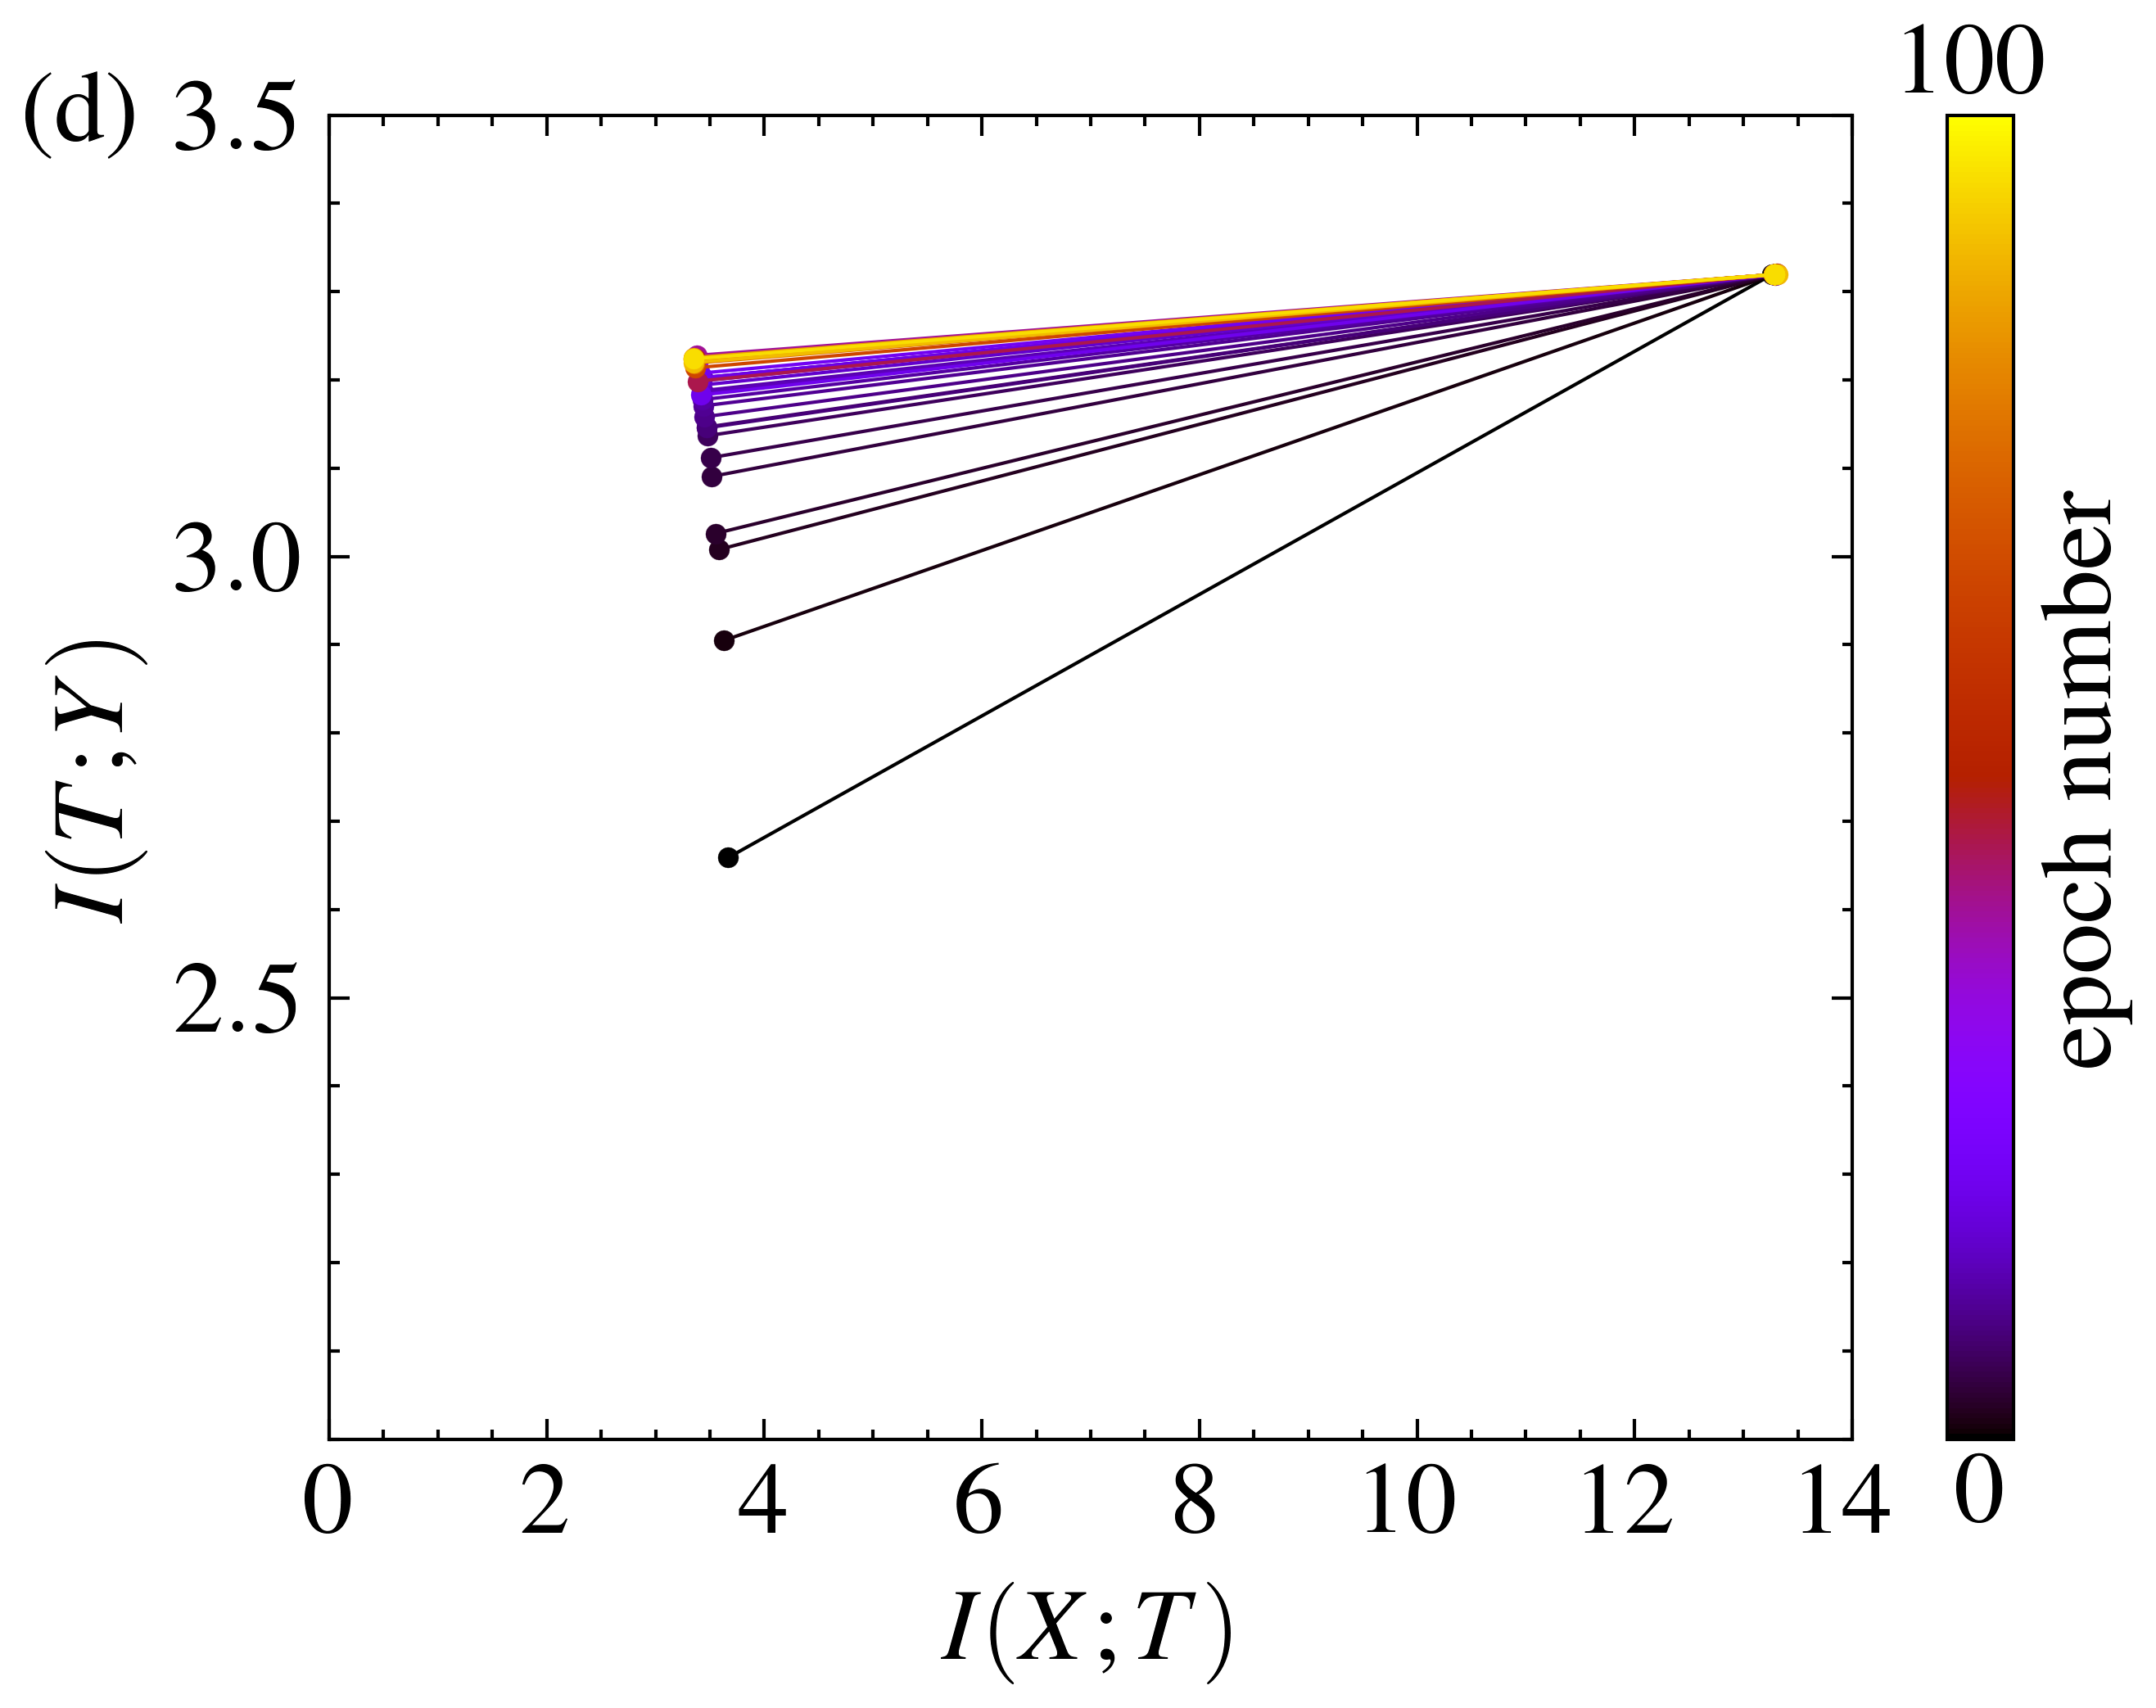

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import torch
import scienceplots
plt.rcParams['font.serif'] = ['Times New Roman']
mpl.rcParams['figure.dpi'] = 800
mpl.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
plt.style.use(['science', 'ieee'])
mpl.rcParams.update({'font.size': 15})

def plot_information_plane(IXT_array, ITY_array, num_epochs, every_n_early=1, every_n_late=5):
    assert len(IXT_array) == len(ITY_array)

    max_index = len(IXT_array)

    fig, ax = plt.subplots(figsize=(5, 3.5))
    ax.set_xlabel('$I(X;T)$', fontsize=15)
    ax.set_ylabel('$I(T;Y)$', fontsize=15)

    cmap = plt.get_cmap('gnuplot')
    colors = [cmap(i) for i in np.linspace(0, 1, num_epochs + 1)]

    for i in range(0, max_index):
        IXT = IXT_array[i, :]
        ITY = ITY_array[i, :]
        
        # 根据 epoch 的范围调整 every_n
        if i < 20:
            color_idx = i * every_n_early
        else:
            color_idx = 20 * every_n_early + (i - 20) * every_n_late

        ax.plot(IXT, ITY, marker='o', markersize=3, markeredgewidth=0.04,
                linestyle='-', linewidth=0.5, color=colors[color_idx], zorder=10)

    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=1))
    sm._A = []

    # 使用ax参数指定颜色条位置
    cbar = plt.colorbar(sm, ax=ax, ticks=[])
    cbar.set_label('epoch number', fontsize=15)
    cbar.ax.tick_params(labelsize=15)
    cbar.ax.text(0.5, -0.01, 0, transform=cbar.ax.transAxes, va='top', ha='center')
    cbar.ax.text(0.5, 1.0, str(num_epochs), transform=cbar.ax.transAxes, va='bottom', ha='center')

    ax.set_xticks([0, 2, 4, 6, 8, 10, 12, 14])
    ax.set_yticks([2.5, 3.0, 3.5])
    ax.set_ylim(2.0, 3.5)  # 修改y轴坐标范围
    # Adjust coordinates of text according to the plot area
    ax.text(-0.2, 0.98, '(d)', fontdict={'size': 15, 'color': 'black'}, transform=ax.transAxes)

    fig.savefig('D:/深度学习与信息论/Fig8dd.eps', dpi=800)
    plt.show()

IXT_array = np.load('D:/深度学习与信息论/MI_XM_upper_arrayG.npy')
ITY_array = np.load('D:/深度学习与信息论/MI_YM_upper_arrayG.npy')


plot_information_plane(IXT_array, ITY_array, num_epochs=100, every_n_early=1, every_n_late=5)

In [18]:
IXT_array

array([[13.2904231 , 13.28280629, 13.28051802, 13.26429105,  3.66701294],
       [13.28901422, 13.28315851, 13.28615355, 13.28105592,  3.62748135],
       [13.29183198, 13.28227796, 13.28680158, 13.28432978,  3.58157408],
       [13.29359309, 13.29178791, 13.28713178, 13.28556737,  3.55121749],
       [13.29324087, 13.28104519, 13.28731477, 13.28613698,  3.51703867],
       [13.29394531, 13.28861793, 13.28742484, 13.28653185,  3.50923328],
       [13.29007088, 13.28491961, 13.28752115, 13.28678226,  3.47937431],
       [13.29641085, 13.28615238, 13.28755555, 13.28690127,  3.46747098],
       [13.28901422, 13.28104519, 13.28763328, 13.28715443,  3.47060059],
       [13.28584424, 13.28914626, 13.28768901, 13.28720809,  3.44806624],
       [13.29500197, 13.29055514, 13.28768763, 13.28721703,  3.44111231],
       [13.29394531, 13.29125958, 13.28769245, 13.28718745,  3.43482189],
       [13.29746751, 13.28509572, 13.28769657, 13.28727   ,  3.42883893],
       [13.28267425, 13.29531012, 13.2

In [19]:
ITY_array

array([[3.31971149, 3.319303  , 3.31942268, 3.31942078, 2.65871044],
       [3.31938522, 3.31929902, 3.31942328, 3.31942187, 2.90475218],
       [3.31950195, 3.31934743, 3.31942337, 3.31942289, 3.00776601],
       [3.31976728, 3.31933067, 3.31942331, 3.31942078, 3.02597139],
       [3.31963921, 3.31926182, 3.31942212, 3.31942136, 3.09062306],
       [3.3198099 , 3.31922253, 3.31942268, 3.31942168, 3.11190628],
       [3.31983561, 3.31938706, 3.31942206, 3.31942211, 3.13674314],
       [3.31969204, 3.31918744, 3.31942144, 3.31942276, 3.1465393 ],
       [3.31936501, 3.3191967 , 3.3194213 , 3.3194223 , 3.14574683],
       [3.31961188, 3.31914654, 3.31942323, 3.31942324, 3.15821857],
       [3.31978943, 3.31940555, 3.31942366, 3.31942168, 3.17061108],
       [3.31951509, 3.31928593, 3.31942468, 3.31942227, 3.17768025],
       [3.31964597, 3.31956856, 3.319424  , 3.31942115, 3.1877702 ],
       [3.31984885, 3.31952624, 3.31942265, 3.31942116, 3.18586394],
       [3.31938441, 3.31937314, 3.

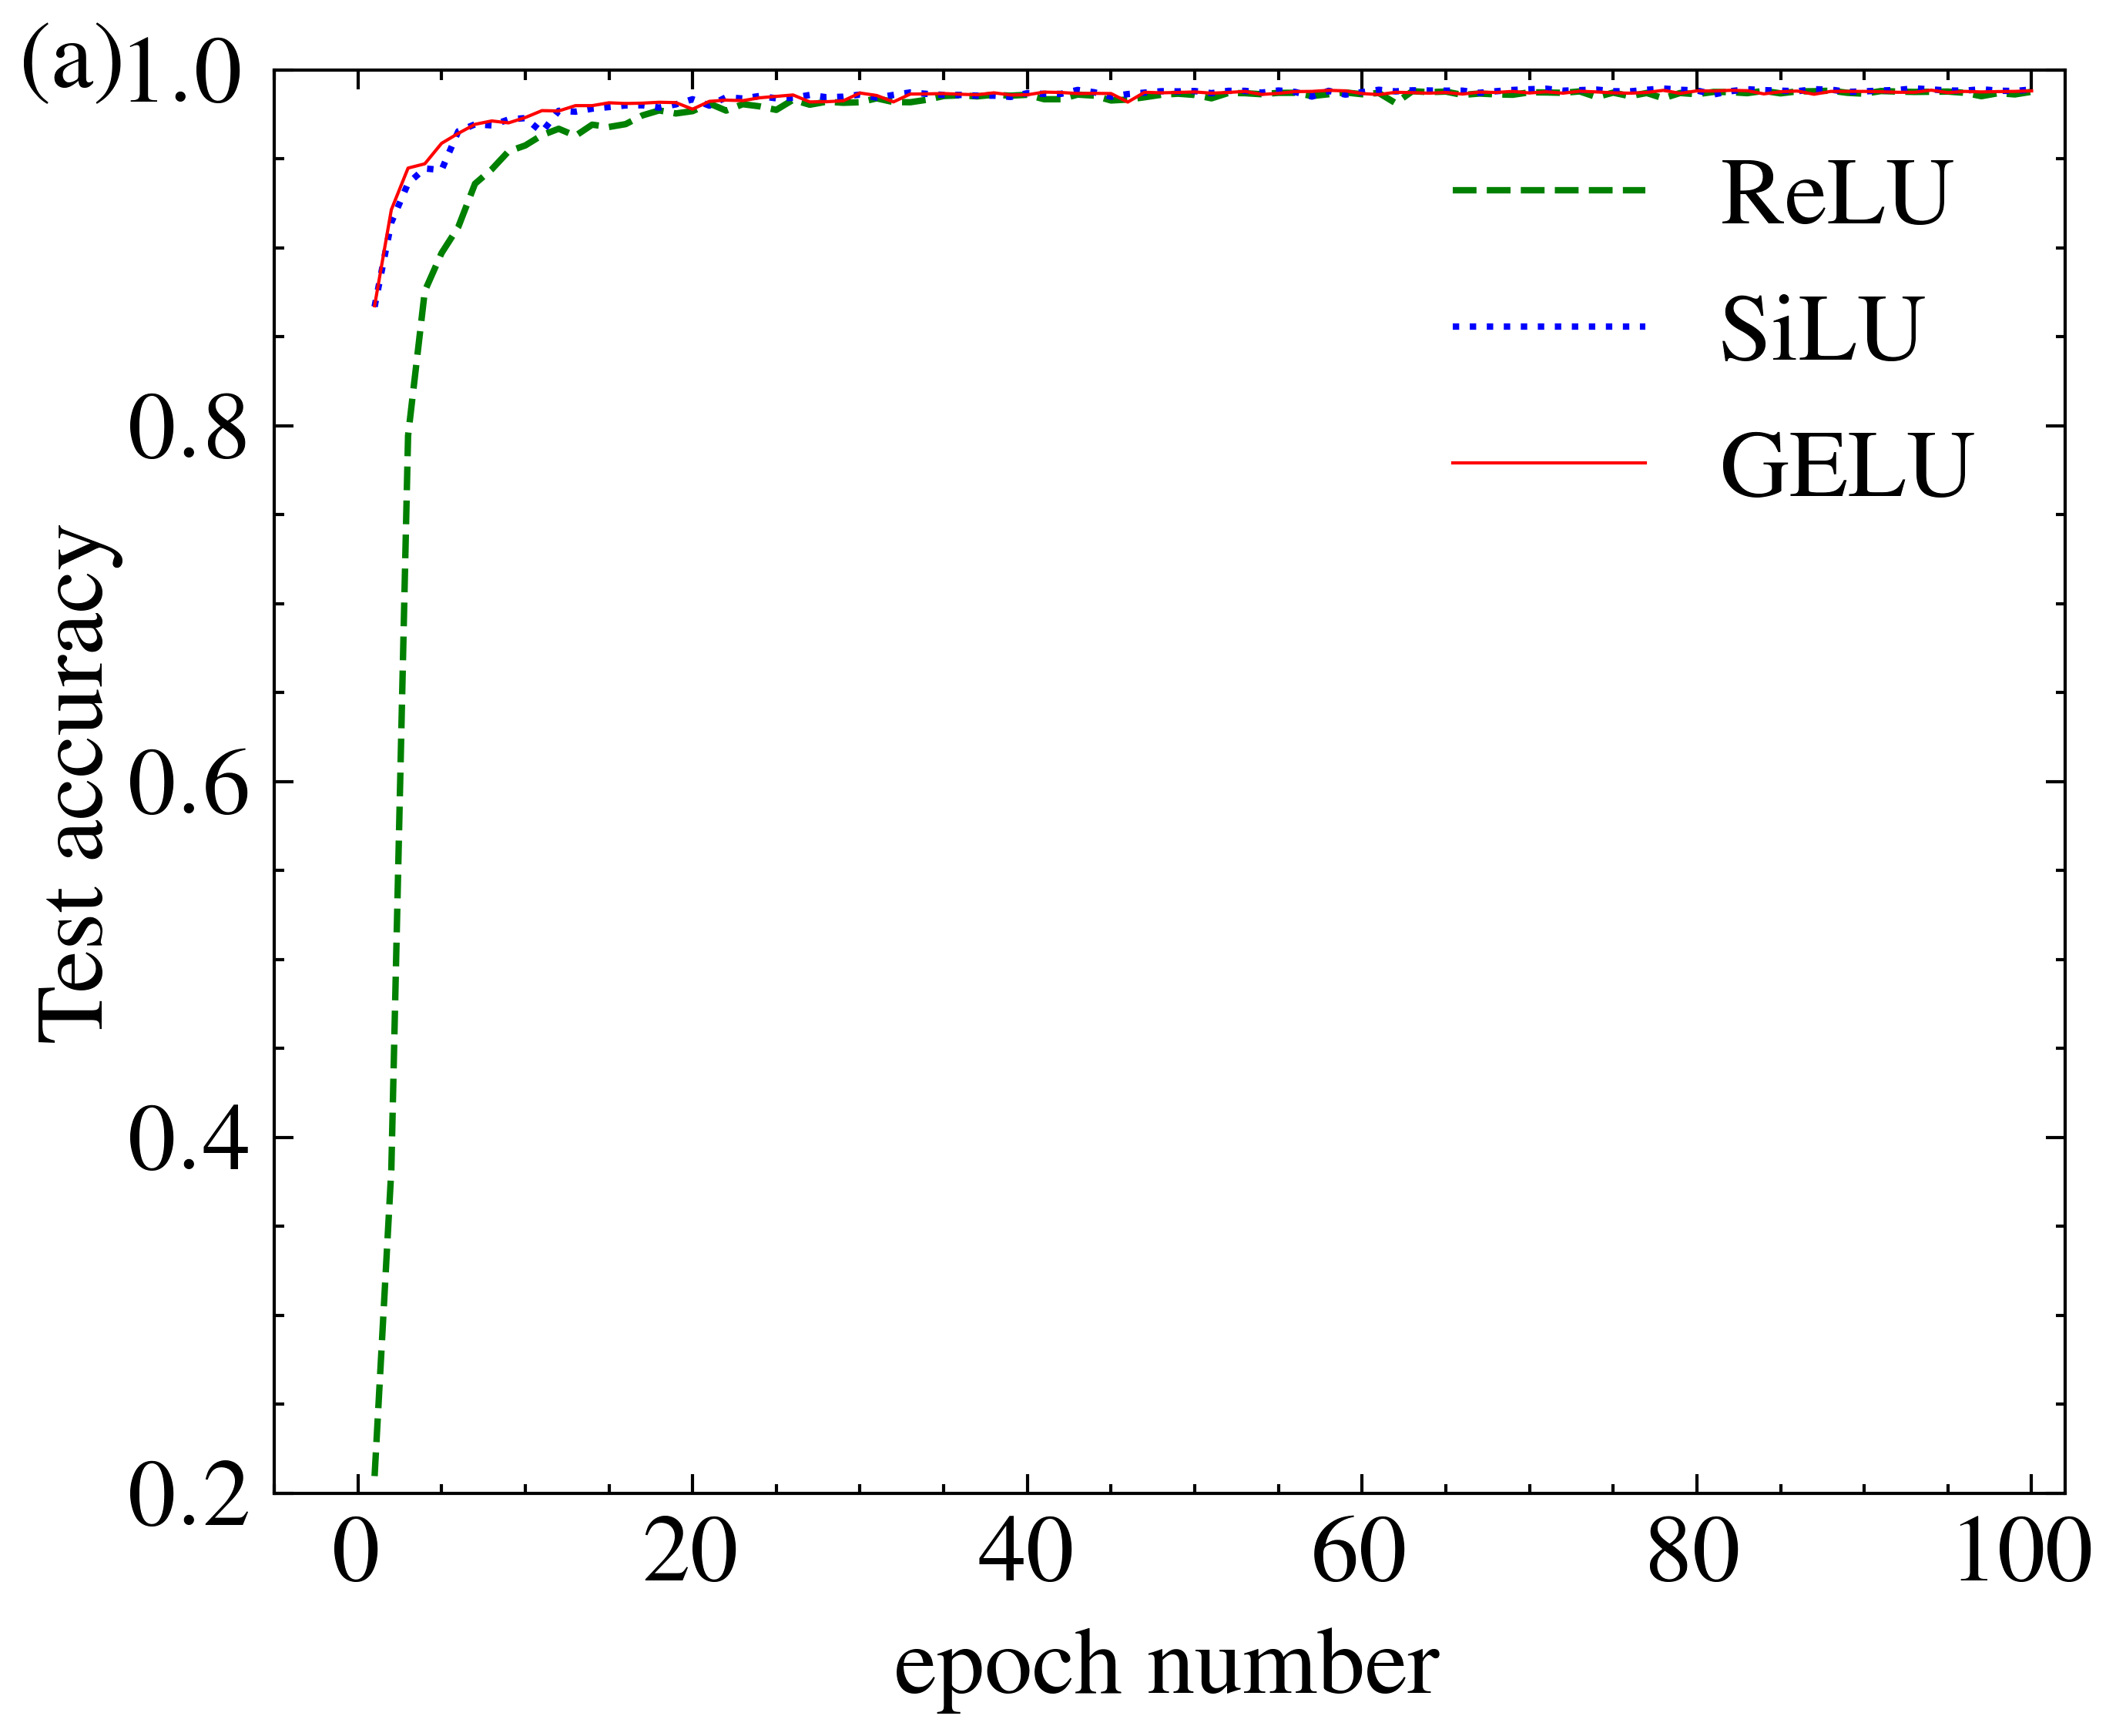

In [24]:
accuracyReLU = np.array([
    20.96, 38.20, 79.44, 87.57, 89.70, 91.17, 93.60, 94.41, 95.42, 95.75,
    96.33, 96.69, 96.29, 96.92, 96.79, 96.95, 97.44, 97.72, 97.55, 97.68,
    98.11, 97.71, 98.07, 97.95, 97.75, 98.32, 98.04, 98.21, 98.15, 98.18,
    98.40, 98.19, 98.18, 98.32, 98.53, 98.57, 98.51, 98.60, 98.55, 98.60,
    98.35, 98.35, 98.61, 98.55, 98.28, 98.33, 98.46, 98.60, 98.66, 98.59,
    98.40, 98.70, 98.69, 98.63, 98.71, 98.71, 98.53, 98.63, 98.73, 98.63,
    98.70, 98.13, 98.80, 98.75, 98.78, 98.59, 98.67, 98.62, 98.60, 98.74,
    98.73, 98.71, 98.79, 98.47, 98.72, 98.52, 98.70, 98.40, 98.70, 98.63,
    98.76, 98.75, 98.69, 98.82, 98.68, 98.79, 98.80, 98.83, 98.71, 98.66,
    98.81, 98.78, 98.76, 98.77, 98.78, 98.71, 98.52, 98.69, 98.62, 98.77])

accuracyS= np.array([
    86.69, 91.43, 93.62, 94.46, 94.37, 96.55, 96.94, 96.88, 97.21, 97.29, 
    96.50, 97.70, 97.65, 97.82, 97.91, 98.00, 98.01, 97.88, 98.06, 98.35, 
    97.99, 98.46, 98.39, 98.53, 98.40, 98.43, 98.59, 98.46, 98.49, 98.61, 
    98.44, 98.59, 98.73, 98.65, 98.59, 98.59, 98.55, 98.55, 98.48, 98.69, 
    98.65, 98.65, 98.87, 98.74, 98.49, 98.64, 98.72, 98.80, 98.79, 98.81, 
    98.69, 98.82, 98.82, 98.72, 98.84, 98.76, 98.50, 98.82, 98.61, 98.75, 
    98.88, 98.79, 98.85, 98.84, 98.83, 98.83, 98.71, 98.80, 98.87, 98.91, 
    98.94, 98.83, 98.86, 98.89, 98.80, 98.79, 98.88, 98.95, 98.88, 98.84, 
    98.62, 98.80, 98.91, 98.86, 98.83, 98.80, 98.91, 98.89, 98.76, 98.79, 
    98.84, 98.87, 98.96, 98.90, 98.84, 98.83, 98.91, 98.83, 98.81, 98.90])


accuracyG = np.array([
    86.74, 92.14, 94.48, 94.72, 95.87, 96.43, 96.94, 97.13, 97.02, 97.32, 
    97.71, 97.69, 97.99, 97.99, 98.15, 98.11, 98.13, 98.18, 98.16, 97.79, 
    98.23, 98.30, 98.27, 98.43, 98.51, 98.59, 98.20, 98.21, 98.26, 98.70, 
    98.56, 98.20, 98.64, 98.65, 98.67, 98.63, 98.60, 98.71, 98.59, 98.60, 
    98.75, 98.73, 98.67, 98.68, 98.67, 98.19, 98.74, 98.71, 98.73, 98.76, 
    98.69, 98.73, 98.79, 98.62, 98.68, 98.78, 98.79, 98.85, 98.82, 98.67, 
    98.61, 98.74, 98.72, 98.69, 98.73, 98.64, 98.75, 98.73, 98.79, 98.70, 
    98.77, 98.69, 98.80, 98.76, 98.71, 98.69, 98.73, 98.85, 98.68, 98.82, 
    98.81, 98.85, 98.83, 98.65, 98.77, 98.81, 98.63, 98.79, 98.79, 98.79, 
    98.77, 98.74, 98.74, 98.86, 98.72, 98.79, 98.76, 98.78, 98.79, 98.82])


import matplotlib.pyplot as plt
import matplotlib as mpl
import scienceplots

plt.rcParams['font.serif'] = ['Times New Roman']
mpl.rcParams['figure.dpi'] = 800
mpl.rcParams['axes.unicode_minus'] = False

plt.rcParams['text.usetex'] = True
plt.rcParams['text.latex.preamble'] = r'\usepackage{amsmath, amssymb}'
plt.style.use(['science','ieee'])

fig, ax = plt.subplots(figsize=(5, 4))
plt.cla()
plt.tick_params(labelsize=15)
ax.set_xlabel('epoch number', fontsize=15)
ax.set_ylabel(r"Test accuracy", fontsize=15, labelpad=1)
ax.set_xlim(-5, len(accuracyReLU)+2)  # Adjust x-axis limits to start from epoch 1
ax.set_ylim(0.2, 1)

# Create the x-axis array to represent epoch numbers
epochs = np.arange(1, len(accuracyReLU) + 1)

# Plot the accuracy curves
ax.plot(epochs, 0.01*accuracyReLU, 'g--', lw=1, label=r"ReLU")
ax.plot(epochs, 0.01*accuracyS, 'b:', lw=1, label=r"SiLU")
ax.plot(epochs, 0.01*accuracyG, 'r-', lw=0.5, label=r"GELU")

ax.text(-20, 0.99, '(a)', fontdict={'size': 15, 'color': 'black'})
ax.legend(loc='upper right', fontsize=15)

# patch = mpl.patches.Rectangle((0.980,85),0.022,15,linewidth=1,linestyle='--',edgecolor='gray',facecolor='none')
# ax.add_patch(patch)
# left, bottom, width, height = [0.3, 0.2, 0.57, 0.3]
# ax2 = fig.add_axes([left, bottom, width, height])

# step = np.arange(1,101)

# ax2.plot(step[85:], 0.01*accuracyReLU[85:], 'g--')
# ax2.plot(step[85:], 0.01*accuracyS[85:], 'b:')
# ax2.plot(step[85:], 0.01*accuracyG[85:], 'r-')
# ax2.set_yticks([0.980,0.982,0.984,0.986])

plt.show()

fig.savefig('D:/深度学习与信息论/Fig8a.eps', dpi=800)
